## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'agriVision-full' 
TRANSFORM = 'fourier'
CHANNEL = 'red'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
red_fourier_full_agriVision.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'c:\\Users\\riyap\\OneDrive\\Documents\\GitHub\\hierarchical-bayesian-model-validation\\results\\case-studies\\agriVision\\full\\fourier\\red'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if TRANSFORM == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif TRANSFORM == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 45000,
 3: 72000,
 4: 63000,
 5: 117000,
 6: 126000,
 7: 171000,
 8: 189000,
 9: 297000,
 10: 396000,
 11: 495000,
 12: 648000,
 13: 882000,
 14: 1134000,
 15: 1539000,
 16: 1953000,
 17: 2574000,
 18: 3456000,
 19: 4563000,
 20: 5967000,
 21: 8010000,
 22: 10395000,
 23: 13887000,
 24: 18297000,
 25: 24057000,
 26: 31968000,
 27: 42183000,
 28: 55764000,
 29: 73701000,
 30: 97326000,
 31: 108342000,
 32: 59634000,
 33: 21420000}

Running 12760 CDFs


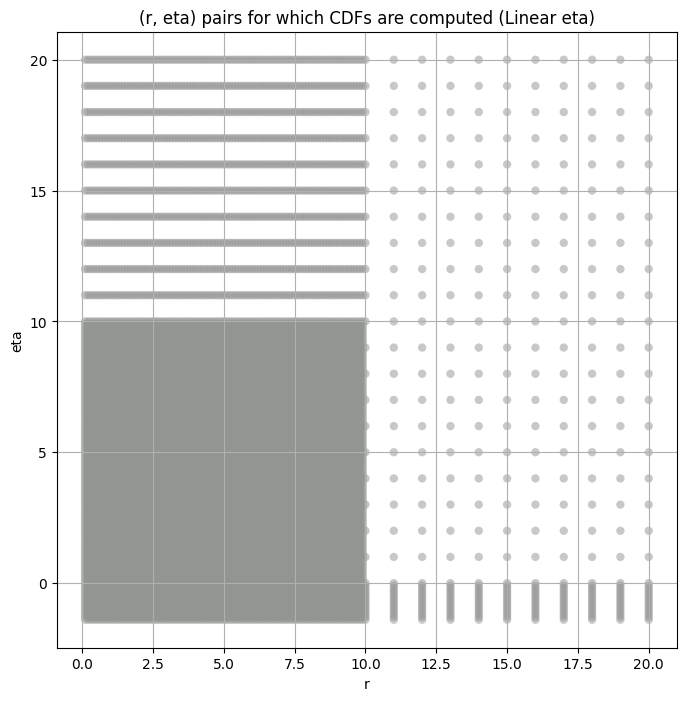

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


100%|██████████| 100000/100000 [01:34<00:00, 1060.14it/s]


Band 5


100%|██████████| 100000/100000 [01:33<00:00, 1072.06it/s]


Band 8


100%|██████████| 100000/100000 [01:09<00:00, 1430.06it/s]


Band 11


100%|██████████| 100000/100000 [01:16<00:00, 1311.01it/s]


Band 14


100%|██████████| 100000/100000 [01:16<00:00, 1307.98it/s]


Band 17


100%|██████████| 100000/100000 [01:07<00:00, 1478.50it/s]


Band 20


100%|██████████| 100000/100000 [01:10<00:00, 1412.19it/s]


Band 23


100%|██████████| 100000/100000 [01:11<00:00, 1401.75it/s]


Band 26


100%|██████████| 100000/100000 [01:09<00:00, 1445.91it/s]


Band 29


100%|██████████| 100000/100000 [01:12<00:00, 1383.69it/s]


Band 32


100%|██████████| 100000/100000 [01:07<00:00, 1482.13it/s]


obs_var   var_lower    var_upper     obs_kurt  kurt_lower  \
band                                                                  
2     1690.463300  778.425800  4474.268600   1951.21090   93.389990   
5      925.186340  445.423340  2432.551000   1732.74070  102.459850   
8      286.479130  157.758420   630.313350    997.55035   76.816630   
11     254.842960   72.829560  1635.355600  13976.00800   62.877470   
14      74.946200   35.321682   283.324700   4449.84300   48.653390   
17      34.729362   17.269596   129.885730   4455.63230   42.402900   
20      15.656890    7.718547    51.575360   3024.86230   61.902660   
23       7.015059    2.579246    40.182514  11453.02000   71.847640   
26       4.446219    0.765977    42.104828  27543.82800   79.598564   
29       1.485536    0.097734    14.558654  38067.58200  100.885220   
32       0.048399    0.010321     0.300186  13939.49500   95.461980   

      kurt_upper  total_samples  
band                             
2      3809.4540        45000.0  
5      3959.4731       117000.0  
8      2699.5813       189000.0  
11     8349.7330       495000.0  
14     6157.9995      1134000.0  
17     6093.3640      2574000.0  
20     4879.5195      5967000.0  
23     7815.2046     13887000.0  
26     9199.3900     31968000.0  
29     9678.4180     73701000.0  
32     8480.3460     59634000.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
band                                                               
2     1690.463300    1690.463257      670.607117      538.211914   
5      925.186340     925.186340      472.731659      391.053009   
8      286.479130     286.479126      166.899384      143.654755   
11     254.842960     254.842957       75.877129       66.189560   
14      74.946200      74.946198       36.782223       32.668171   
17      34.729362      34.729362       17.975048       16.125875   
20      15.656890      15.656890        8.102229        7.056667   
23       7.015059       7.015059        2.706648        2.325729   
26       4.446219       4.446219        0.802676        0.683208   
29       1.485536       1.485536        0.102684        0.085097   
32       0.048399       0.048399        0.010792        0.008975   

      var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
band                                                                      
2         469.132568       429.836121       382.471222       349.825775   
5         345.650391       316.010468       275.283966       248.062805   
8         129.325165       119.133240       104.875336        95.755943   
11         60.573044        56.633175        51.206039        47.455677   
14         30.298340        28.613720        26.274021        24.630728   
17         15.033867        14.250858        13.149749        12.379282   
20          6.450524         6.033005         5.466999         5.091034   
23          2.102765         1.951631         1.755341         1.628585   
26          0.615964         0.570483         0.510550         0.471294   
29          0.075573         0.069411         0.061638         0.056719   
32          0.008016         0.007407         0.006647         0.006165   

      var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
band                                                                      
2          325.676941       306.646698       291.018158       255.738937  
5          228.121231       212.973358       200.773697       174.630707  
8           89.167236        84.014374        79.883942        70.752922  
11          44.661514        42.479553        40.694813        36.710758  
14          23.381010        22.380789        21.553862        19.697079  
17          11.793085        11.321042        10.924714        10.022984  
20           4.814970         4.599360         4.422770         4.030481  
23           1.536807         1.465151         1.406387         1.274405  
26           0.442577         0.420016         0.401465         0.359903  
29           0.053171         0.050392         0.048101         0.042935  
32           0.005814         0.005536         0.005305         0.004776

####
Band  2


  0%|          | 19/12760 [00:00<01:07, 187.57it/s]

100%|██████████| 12760/12760 [00:50<00:00, 252.90it/s]


Finding Minimum after computing 12760 CDFs
2 0 0.0340422054999143 1690.4633


100%|██████████| 12760/12760 [00:52<00:00, 242.10it/s]


Finding Minimum after computing 12760 CDFs
2 25 0.015257819151234697 670.6071


100%|██████████| 12760/12760 [01:00<00:00, 211.35it/s]


Finding Minimum after computing 12760 CDFs
2 50 0.010595268088289603 538.2119


100%|██████████| 12760/12760 [01:02<00:00, 205.48it/s]


Finding Minimum after computing 12760 CDFs
2 75 0.007414602522393954 469.13257


100%|██████████| 12760/12760 [00:58<00:00, 218.26it/s]


Finding Minimum after computing 12760 CDFs
2 100 0.006183053503059033 429.83612


100%|██████████| 12760/12760 [01:01<00:00, 208.03it/s]


Finding Minimum after computing 12760 CDFs
2 150 0.006941527841491046 382.47122


100%|██████████| 12760/12760 [01:00<00:00, 209.72it/s]


Finding Minimum after computing 12760 CDFs
2 200 0.007870246586842544 349.82578


100%|██████████| 12760/12760 [01:00<00:00, 209.42it/s]


Finding Minimum after computing 12760 CDFs
2 250 0.009295062270481047 325.67694


100%|██████████| 12760/12760 [01:06<00:00, 190.72it/s]


Finding Minimum after computing 12760 CDFs
2 300 0.010680351013546363 306.6467


100%|██████████| 12760/12760 [01:06<00:00, 190.90it/s]


Finding Minimum after computing 12760 CDFs
2 350 0.012137857344206027 291.01816


100%|██████████| 12760/12760 [01:02<00:00, 205.28it/s]


Finding Minimum after computing 12760 CDFs
2 500 0.016175157684933827 255.73894
Number of samples: 45000, Without approximation : 45000.0


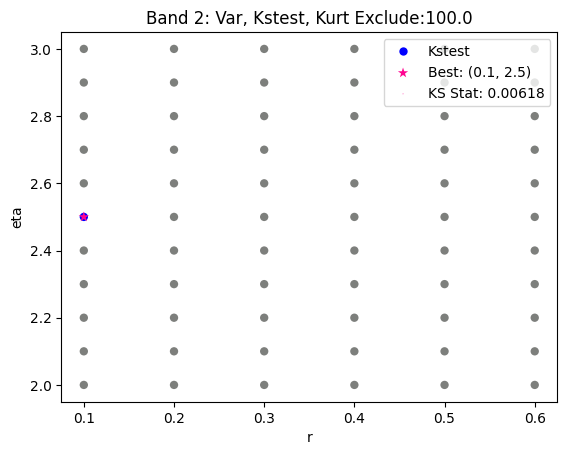

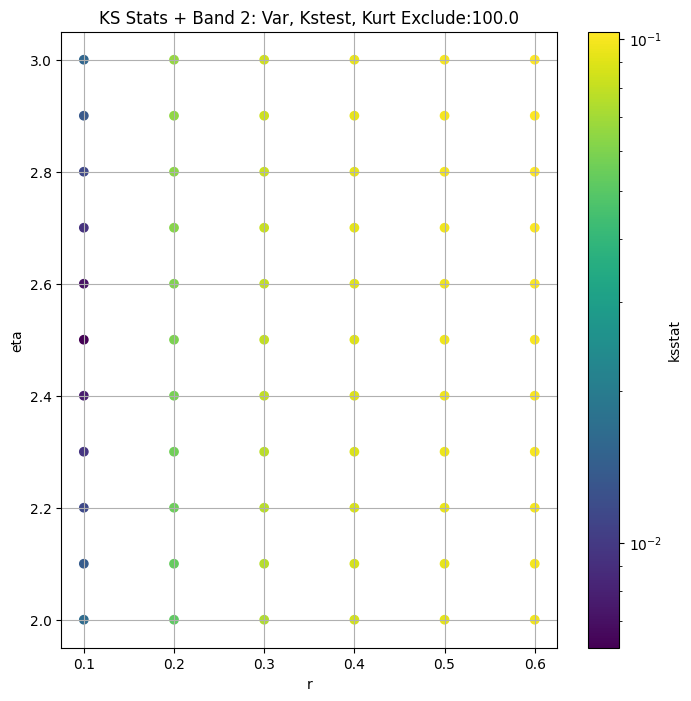

####
Band  5


100%|██████████| 12760/12760 [02:27<00:00, 86.50it/s] 


Finding Minimum after computing 12760 CDFs
5 0 0.03682867848262321 925.18634


100%|██████████| 12760/12760 [02:24<00:00, 88.07it/s] 


Finding Minimum after computing 12760 CDFs
5 25 0.02380486436260558 472.73166


100%|██████████| 12760/12760 [02:21<00:00, 90.14it/s] 


Finding Minimum after computing 12760 CDFs
5 50 0.019306364295522627 391.053


100%|██████████| 12760/12760 [02:24<00:00, 88.04it/s] 


Finding Minimum after computing 12760 CDFs
5 75 0.016627624466001856 345.6504


100%|██████████| 12760/12760 [02:20<00:00, 90.92it/s] 


Finding Minimum after computing 12760 CDFs
5 100 0.014852977828076513 316.01047


100%|██████████| 12760/12760 [02:21<00:00, 90.08it/s] 


Finding Minimum after computing 12760 CDFs
5 150 0.011917700957933888 275.28397


100%|██████████| 12760/12760 [02:16<00:00, 93.22it/s] 


Finding Minimum after computing 12760 CDFs
5 200 0.009744422176560352 248.0628


100%|██████████| 12760/12760 [02:20<00:00, 90.50it/s] 


Finding Minimum after computing 12760 CDFs
5 250 0.007409794111335216 228.12123


100%|██████████| 12760/12760 [02:15<00:00, 94.00it/s] 


Finding Minimum after computing 12760 CDFs
5 300 0.005491704915761994 212.97336


100%|██████████| 12760/12760 [02:18<00:00, 91.91it/s] 


Finding Minimum after computing 12760 CDFs
5 350 0.00538454334356843 200.7737


100%|██████████| 12760/12760 [02:24<00:00, 88.22it/s] 


Finding Minimum after computing 12760 CDFs
5 500 0.007102352028923809 174.6307
Number of samples: 100000, Without approximation : 117000.0


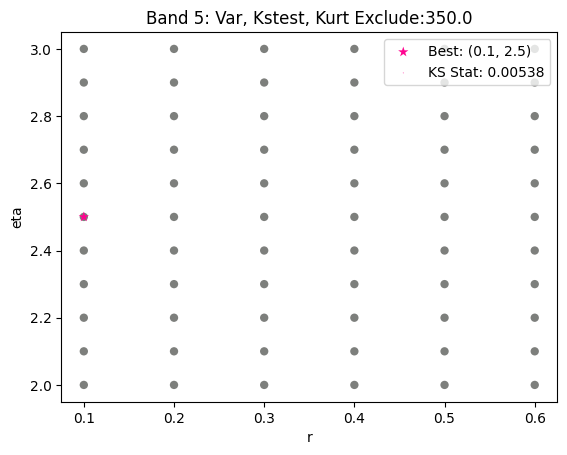

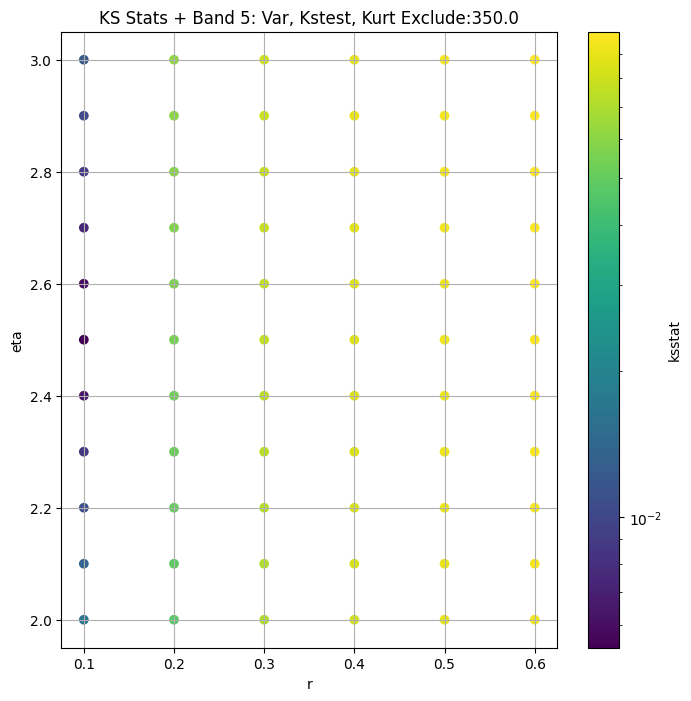

####
Band  8


100%|██████████| 12760/12760 [02:19<00:00, 91.53it/s] 


Finding Minimum after computing 12760 CDFs
8 0 0.030350613493812476 286.47913


100%|██████████| 12760/12760 [02:29<00:00, 85.56it/s] 


Finding Minimum after computing 12760 CDFs
8 25 0.019464366587760476 166.89938


100%|██████████| 12760/12760 [02:30<00:00, 85.05it/s] 


Finding Minimum after computing 12760 CDFs
8 50 0.016268958186886492 143.65475


100%|██████████| 12760/12760 [02:19<00:00, 91.26it/s] 


Finding Minimum after computing 12760 CDFs
8 75 0.014406063433900385 129.32516


100%|██████████| 12760/12760 [02:24<00:00, 88.21it/s] 


Finding Minimum after computing 12760 CDFs
8 100 0.012511549432955155 119.13324


100%|██████████| 12760/12760 [02:21<00:00, 90.05it/s] 


Finding Minimum after computing 12760 CDFs
8 150 0.009226440832803884 104.875336


100%|██████████| 12760/12760 [02:22<00:00, 89.79it/s] 


Finding Minimum after computing 12760 CDFs
8 200 0.007011409107290895 95.75594


100%|██████████| 12760/12760 [02:21<00:00, 90.09it/s] 


Finding Minimum after computing 12760 CDFs
8 250 0.005415698493849638 89.16724


100%|██████████| 12760/12760 [02:20<00:00, 90.90it/s] 


Finding Minimum after computing 12760 CDFs
8 300 0.0044803650922471405 84.01437


100%|██████████| 12760/12760 [02:17<00:00, 92.59it/s] 


Finding Minimum after computing 12760 CDFs
8 350 0.005095519282312222 79.88394


100%|██████████| 12760/12760 [02:19<00:00, 91.19it/s] 


Finding Minimum after computing 12760 CDFs
8 500 0.006829335832825079 70.75292
Number of samples: 100000, Without approximation : 189000.0


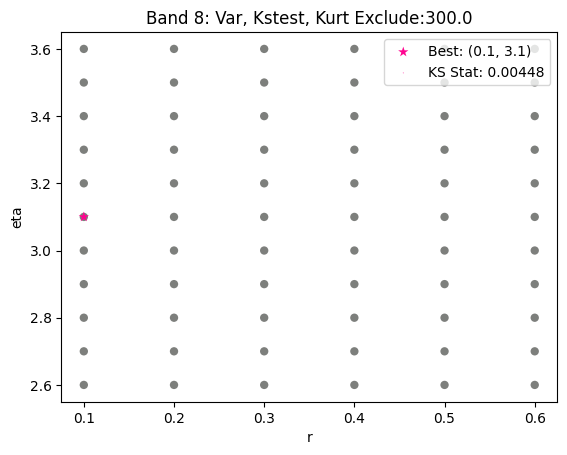

####
Band  11


100%|██████████| 12760/12760 [02:22<00:00, 89.79it/s] 


Finding Minimum after computing 12760 CDFs
11 0 0.042134962501646056 254.84296


100%|██████████| 12760/12760 [02:21<00:00, 90.25it/s] 


Finding Minimum after computing 12760 CDFs
11 25 0.016197934667208203 75.87713


100%|██████████| 12760/12760 [02:21<00:00, 90.17it/s] 


Finding Minimum after computing 12760 CDFs
11 50 0.012620165062139144 66.18956


100%|██████████| 12760/12760 [02:21<00:00, 90.41it/s] 


Finding Minimum after computing 12760 CDFs
11 75 0.010312100767259427 60.573044


100%|██████████| 12760/12760 [02:22<00:00, 89.30it/s] 


Finding Minimum after computing 12760 CDFs
11 100 0.008942381537559219 56.633175


100%|██████████| 12760/12760 [02:19<00:00, 91.71it/s] 


Finding Minimum after computing 12760 CDFs
11 150 0.006538758370736808 51.20604


100%|██████████| 12760/12760 [02:20<00:00, 90.52it/s] 


Finding Minimum after computing 12760 CDFs
11 200 0.004239538588061198 47.455677


100%|██████████| 12760/12760 [02:20<00:00, 91.10it/s] 


Finding Minimum after computing 12760 CDFs
11 250 0.0035991142652927136 44.661514


100%|██████████| 12760/12760 [02:13<00:00, 95.43it/s] 


Finding Minimum after computing 12760 CDFs
11 300 0.004215225046473314 42.479553


100%|██████████| 12760/12760 [02:14<00:00, 95.00it/s] 


Finding Minimum after computing 12760 CDFs
11 350 0.004837035454005489 40.694813


100%|██████████| 12760/12760 [02:15<00:00, 94.02it/s] 


Finding Minimum after computing 12760 CDFs
11 500 0.00669918840648509 36.71076
Number of samples: 100000, Without approximation : 495000.0


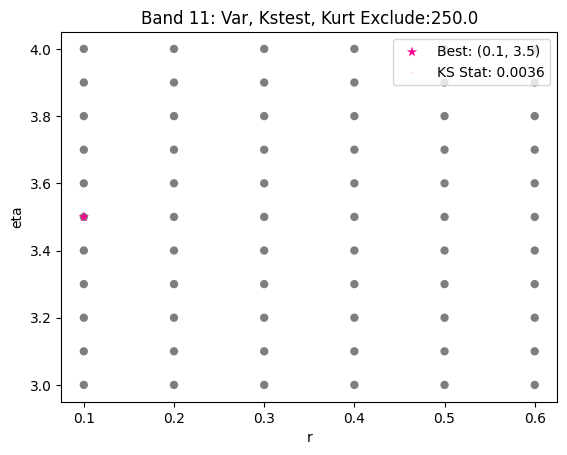

####
Band  14


100%|██████████| 12760/12760 [02:16<00:00, 93.46it/s] 


Finding Minimum after computing 12760 CDFs
14 0 0.02914904857137035 74.9462


100%|██████████| 12760/12760 [02:21<00:00, 90.36it/s] 


Finding Minimum after computing 12760 CDFs
14 25 0.013450813632492647 36.782223


100%|██████████| 12760/12760 [02:18<00:00, 92.35it/s] 


Finding Minimum after computing 12760 CDFs
14 50 0.010549687909344324 32.66817


100%|██████████| 12760/12760 [02:18<00:00, 92.05it/s] 


Finding Minimum after computing 12760 CDFs
14 75 0.008565898252639814 30.29834


100%|██████████| 12760/12760 [02:20<00:00, 90.70it/s] 


Finding Minimum after computing 12760 CDFs
14 100 0.006703820895537713 28.61372


100%|██████████| 12760/12760 [02:18<00:00, 92.06it/s] 


Finding Minimum after computing 12760 CDFs
14 150 0.004355818266685851 26.274021


100%|██████████| 12760/12760 [02:22<00:00, 89.28it/s] 


Finding Minimum after computing 12760 CDFs
14 200 0.0029842795191428184 24.630728


100%|██████████| 12760/12760 [02:30<00:00, 84.53it/s] 


Finding Minimum after computing 12760 CDFs
14 250 0.003606530510756767 23.38101


100%|██████████| 12760/12760 [02:23<00:00, 89.03it/s] 


Finding Minimum after computing 12760 CDFs
14 300 0.004355490762157799 22.380789


100%|██████████| 12760/12760 [02:18<00:00, 92.19it/s] 


Finding Minimum after computing 12760 CDFs
14 350 0.0049577895565350305 21.553862


100%|██████████| 12760/12760 [02:25<00:00, 87.88it/s] 


Finding Minimum after computing 12760 CDFs
14 500 0.006825956226410579 19.697079
Number of samples: 100000, Without approximation : 1134000.0


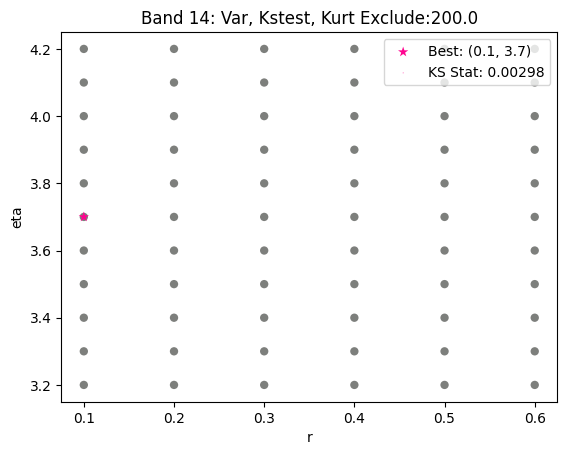

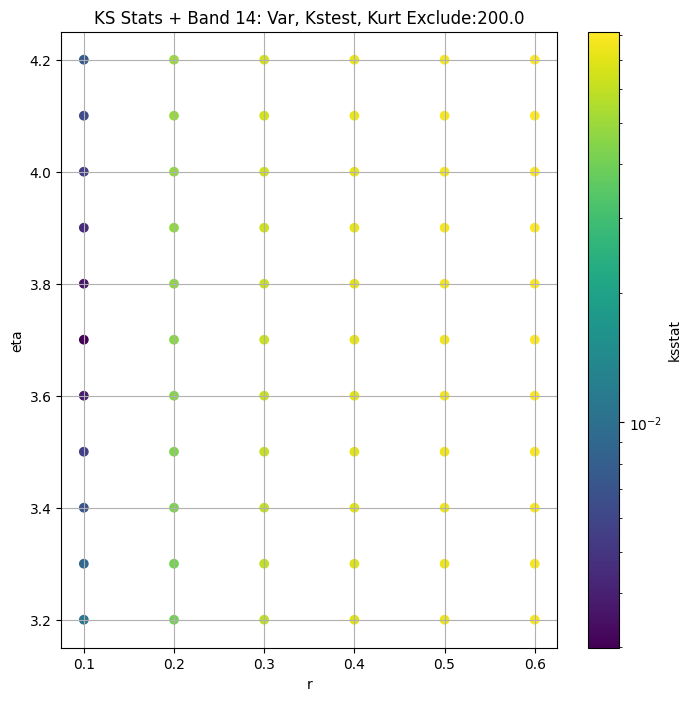

####
Band  17


100%|██████████| 12760/12760 [02:09<00:00, 98.74it/s] 


Finding Minimum after computing 12760 CDFs
17 0 0.027278229019859657 34.729362


100%|██████████| 12760/12760 [01:41<00:00, 125.75it/s]


Finding Minimum after computing 12760 CDFs
17 25 0.011379211599070405 17.975048


100%|██████████| 12760/12760 [01:49<00:00, 116.91it/s]


Finding Minimum after computing 12760 CDFs
17 50 0.008712138507663725 16.125875


100%|██████████| 12760/12760 [01:46<00:00, 119.25it/s]


Finding Minimum after computing 12760 CDFs
17 75 0.00692077609703301 15.033867


100%|██████████| 12760/12760 [01:43<00:00, 122.92it/s]


Finding Minimum after computing 12760 CDFs
17 100 0.00512707621759434 14.250858


100%|██████████| 12760/12760 [01:47<00:00, 118.33it/s]


Finding Minimum after computing 12760 CDFs
17 150 0.0028452465153013806 13.149749


100%|██████████| 12760/12760 [01:44<00:00, 122.46it/s]


Finding Minimum after computing 12760 CDFs
17 200 0.002908154734609646 12.379282


100%|██████████| 12760/12760 [01:48<00:00, 117.58it/s]


Finding Minimum after computing 12760 CDFs
17 250 0.003548775770093795 11.793085


100%|██████████| 12760/12760 [01:44<00:00, 122.15it/s]


Finding Minimum after computing 12760 CDFs
17 300 0.00417017062489098 11.321042


100%|██████████| 12760/12760 [01:46<00:00, 119.69it/s]


Finding Minimum after computing 12760 CDFs
17 350 0.004895098613714087 10.924714


100%|██████████| 12760/12760 [01:46<00:00, 119.58it/s]


Finding Minimum after computing 12760 CDFs
17 500 0.0067366841037321545 10.022984
Number of samples: 100000, Without approximation : 2574000.0


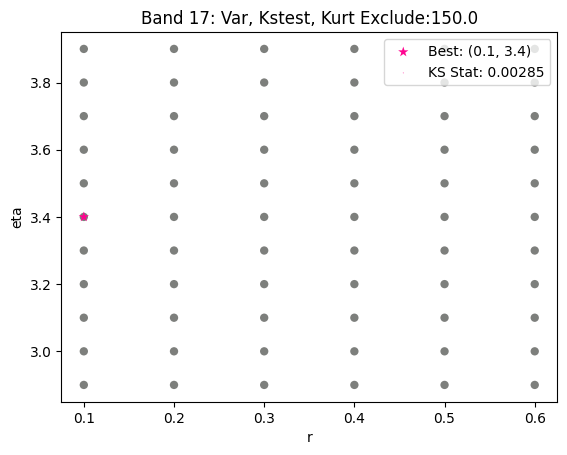

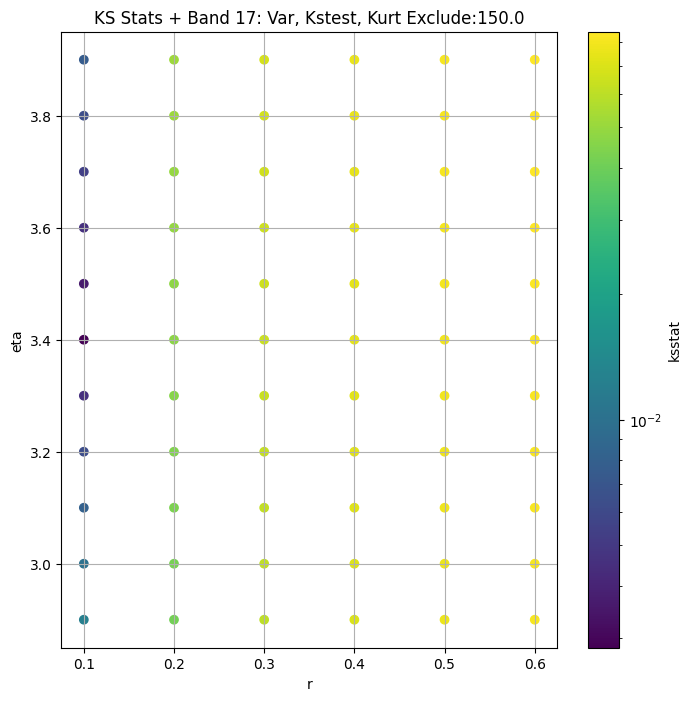

####
Band  20


100%|██████████| 12760/12760 [01:45<00:00, 120.73it/s]


Finding Minimum after computing 12760 CDFs
20 0 0.02877704139550319 15.65689


100%|██████████| 12760/12760 [01:46<00:00, 120.36it/s]


Finding Minimum after computing 12760 CDFs
20 25 0.013903124497001151 8.102229


100%|██████████| 12760/12760 [01:45<00:00, 121.37it/s]


Finding Minimum after computing 12760 CDFs
20 50 0.00981859254807177 7.056667


100%|██████████| 12760/12760 [01:47<00:00, 118.96it/s]


Finding Minimum after computing 12760 CDFs
20 75 0.007583784543045535 6.4505243


100%|██████████| 12760/12760 [01:45<00:00, 120.42it/s]


Finding Minimum after computing 12760 CDFs
20 100 0.0064300390541086605 6.0330048


100%|██████████| 12760/12760 [01:48<00:00, 117.65it/s]


Finding Minimum after computing 12760 CDFs
20 150 0.0037939055230681307 5.466999


100%|██████████| 12760/12760 [01:44<00:00, 122.58it/s]


Finding Minimum after computing 12760 CDFs
20 200 0.002773840563078297 5.091034


100%|██████████| 12760/12760 [01:46<00:00, 119.31it/s]


Finding Minimum after computing 12760 CDFs
20 250 0.0034446113232162318 4.81497


100%|██████████| 12760/12760 [01:47<00:00, 119.10it/s]


Finding Minimum after computing 12760 CDFs
20 300 0.00410999297690679 4.5993595


100%|██████████| 12760/12760 [01:46<00:00, 119.35it/s]


Finding Minimum after computing 12760 CDFs
20 350 0.004925219833250699 4.42277


100%|██████████| 12760/12760 [01:48<00:00, 118.09it/s]


Finding Minimum after computing 12760 CDFs
20 500 0.006800901910254342 4.030481
Number of samples: 100000, Without approximation : 5967000.0


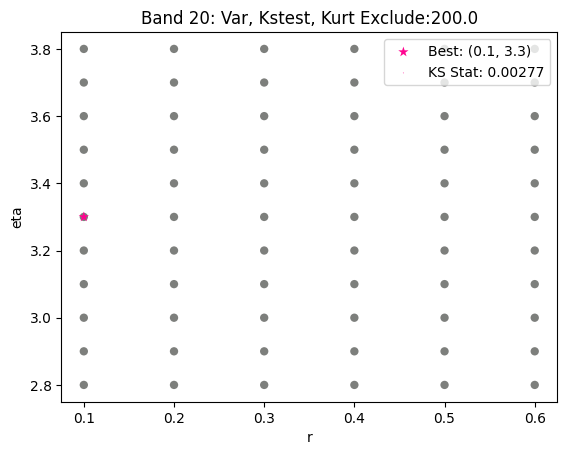

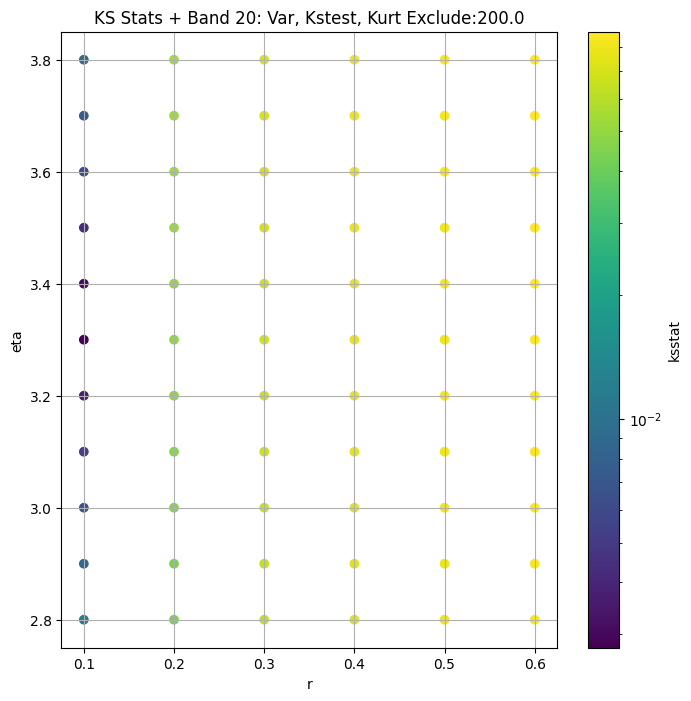

####
Band  23


100%|██████████| 12760/12760 [01:44<00:00, 122.60it/s]


Finding Minimum after computing 12760 CDFs
23 0 0.035830717477120855 7.0150595


100%|██████████| 12760/12760 [01:47<00:00, 118.78it/s]


Finding Minimum after computing 12760 CDFs
23 25 0.01675871637016879 2.7066476


100%|██████████| 12760/12760 [01:44<00:00, 121.59it/s]


Finding Minimum after computing 12760 CDFs
23 50 0.013459537983566805 2.3257291


100%|██████████| 12760/12760 [01:47<00:00, 118.19it/s]


Finding Minimum after computing 12760 CDFs
23 75 0.010797163967970258 2.102765


100%|██████████| 12760/12760 [01:44<00:00, 122.36it/s]


Finding Minimum after computing 12760 CDFs
23 100 0.009547975554160648 1.9516312


100%|██████████| 12760/12760 [01:46<00:00, 119.39it/s]


Finding Minimum after computing 12760 CDFs
23 150 0.006711994002189803 1.7553407


100%|██████████| 12760/12760 [01:46<00:00, 120.11it/s]


Finding Minimum after computing 12760 CDFs
23 200 0.005253255291749914 1.6285849


100%|██████████| 12760/12760 [01:44<00:00, 121.55it/s]


Finding Minimum after computing 12760 CDFs
23 250 0.004336103901898647 1.5368073


100%|██████████| 12760/12760 [01:46<00:00, 119.43it/s]


Finding Minimum after computing 12760 CDFs
23 300 0.004814520081236617 1.4651506


100%|██████████| 12760/12760 [01:44<00:00, 121.96it/s]


Finding Minimum after computing 12760 CDFs
23 350 0.0054549897643455525 1.4063867


100%|██████████| 12760/12760 [01:47<00:00, 118.87it/s]


Finding Minimum after computing 12760 CDFs
23 500 0.007307019267529524 1.2744045
Number of samples: 100000, Without approximation : 13887000.0


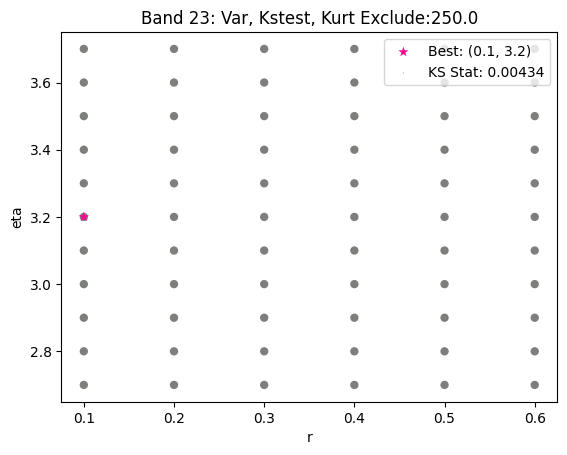

####
Band  26


100%|██████████| 12760/12760 [01:44<00:00, 122.14it/s]


Finding Minimum after computing 12760 CDFs
26 0 0.04748888342609475 4.446219


100%|██████████| 12760/12760 [01:46<00:00, 119.43it/s]


Finding Minimum after computing 12760 CDFs
26 25 0.01665985825558769 0.80267596


100%|██████████| 12760/12760 [01:44<00:00, 121.58it/s]


Finding Minimum after computing 12760 CDFs
26 50 0.012440186390538954 0.68320805


100%|██████████| 12760/12760 [01:46<00:00, 119.85it/s]


Finding Minimum after computing 12760 CDFs
26 75 0.010338967474726346 0.61596423


100%|██████████| 12760/12760 [01:47<00:00, 118.68it/s]


Finding Minimum after computing 12760 CDFs
26 100 0.009062992203261677 0.5704832


100%|██████████| 12760/12760 [01:44<00:00, 122.12it/s]


Finding Minimum after computing 12760 CDFs
26 150 0.0074576546746886185 0.5105496


100%|██████████| 12760/12760 [01:47<00:00, 118.39it/s]


Finding Minimum after computing 12760 CDFs
26 200 0.0059385922069769 0.47129357


100%|██████████| 12760/12760 [01:44<00:00, 122.52it/s]


Finding Minimum after computing 12760 CDFs
26 250 0.004770189720493312 0.44257703


100%|██████████| 12760/12760 [01:46<00:00, 120.27it/s]


Finding Minimum after computing 12760 CDFs
26 300 0.005370145846897434 0.42001644


100%|██████████| 12760/12760 [01:45<00:00, 121.24it/s]


Finding Minimum after computing 12760 CDFs
26 350 0.006177653915601433 0.40146542


100%|██████████| 12760/12760 [01:48<00:00, 117.68it/s]


Finding Minimum after computing 12760 CDFs
26 500 0.007798608784284622 0.35990295
Number of samples: 100000, Without approximation : 31968000.0


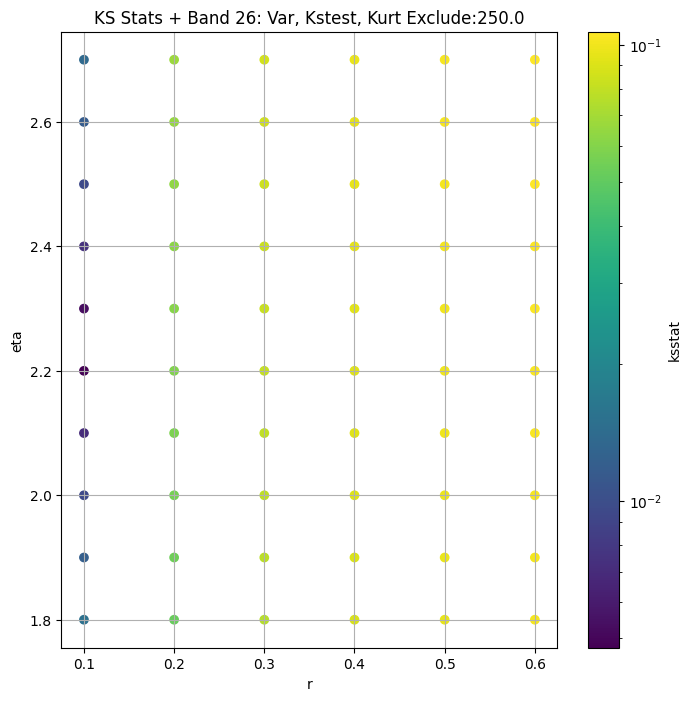

####
Band  29


100%|██████████| 12760/12760 [01:47<00:00, 119.03it/s]


Finding Minimum after computing 12760 CDFs
29 0 0.05594568091630131 1.4855361


100%|██████████| 12760/12760 [01:46<00:00, 119.78it/s]


Finding Minimum after computing 12760 CDFs
29 25 0.01850139572254017 0.102683775


100%|██████████| 12760/12760 [01:46<00:00, 119.43it/s]


Finding Minimum after computing 12760 CDFs
29 50 0.01566238343396531 0.085096754


100%|██████████| 12760/12760 [01:44<00:00, 121.92it/s]


Finding Minimum after computing 12760 CDFs
29 75 0.01322229857969981 0.07557344


100%|██████████| 12760/12760 [01:46<00:00, 119.37it/s]


Finding Minimum after computing 12760 CDFs
29 100 0.01215607269029495 0.069410965


100%|██████████| 12760/12760 [01:45<00:00, 121.15it/s]


Finding Minimum after computing 12760 CDFs
29 150 0.010019664215408453 0.061638135


100%|██████████| 12760/12760 [01:47<00:00, 118.15it/s]


Finding Minimum after computing 12760 CDFs
29 200 0.008620856124492149 0.05671928


100%|██████████| 12760/12760 [01:45<00:00, 120.42it/s]


Finding Minimum after computing 12760 CDFs
29 250 0.007893145504719756 0.053170983


100%|██████████| 12760/12760 [01:48<00:00, 117.71it/s]


Finding Minimum after computing 12760 CDFs
29 300 0.006696383952246587 0.05039177


100%|██████████| 12760/12760 [01:46<00:00, 119.81it/s]


Finding Minimum after computing 12760 CDFs
29 350 0.007718083112038809 0.048100777


100%|██████████| 12760/12760 [01:47<00:00, 118.74it/s]


Finding Minimum after computing 12760 CDFs
29 500 0.00923612120737638 0.04293478
Number of samples: 100000, Without approximation : 73701000.0


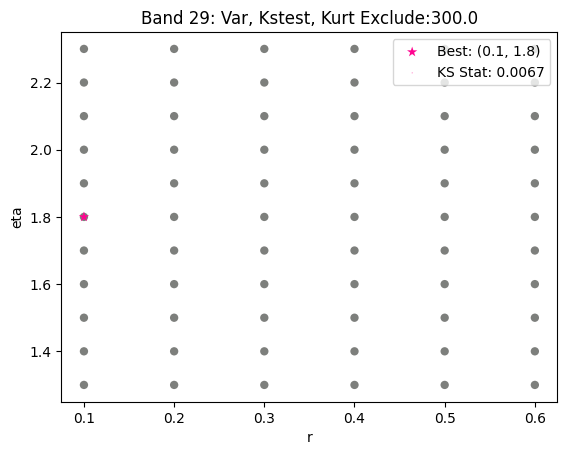

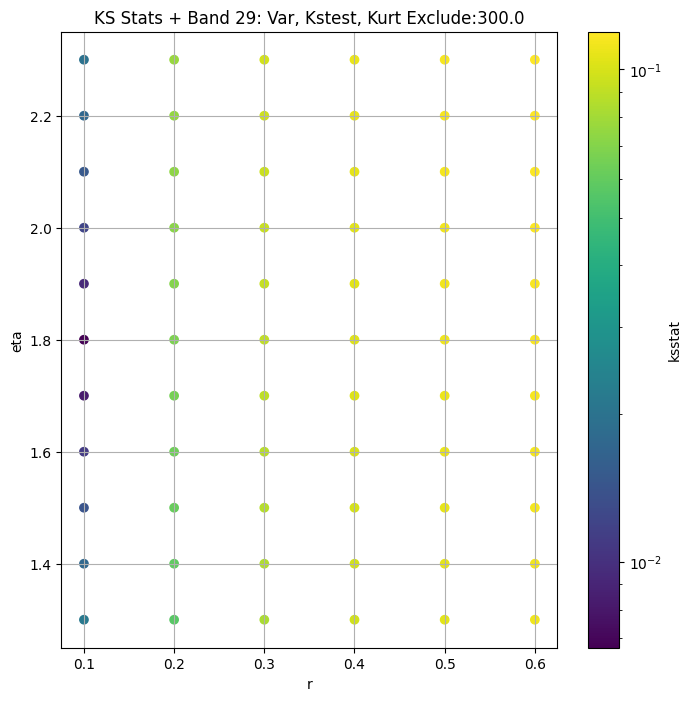

####
Band  32


100%|██████████| 12760/12760 [01:47<00:00, 118.49it/s]


Finding Minimum after computing 12760 CDFs
32 0 0.05035960643807125 0.048398644


100%|██████████| 12760/12760 [01:47<00:00, 118.33it/s]


Finding Minimum after computing 12760 CDFs
32 25 0.02340590036851209 0.010792089


100%|██████████| 12760/12760 [01:48<00:00, 117.98it/s]


Finding Minimum after computing 12760 CDFs
32 50 0.01966473041333955 0.008974528


100%|██████████| 12760/12760 [01:44<00:00, 121.98it/s]


Finding Minimum after computing 12760 CDFs
32 75 0.017664097734406692 0.008015827


100%|██████████| 12760/12760 [01:49<00:00, 116.28it/s]


Finding Minimum after computing 12760 CDFs
32 100 0.01606080646942787 0.00740659


100%|██████████| 12760/12760 [01:46<00:00, 119.49it/s]


Finding Minimum after computing 12760 CDFs
32 150 0.013606630353782512 0.006646596


100%|██████████| 12760/12760 [01:47<00:00, 118.22it/s]


Finding Minimum after computing 12760 CDFs
32 200 0.012126434381734386 0.006164623


100%|██████████| 12760/12760 [01:49<00:00, 116.18it/s]


Finding Minimum after computing 12760 CDFs
32 250 0.01118609322678904 0.005813837


100%|██████████| 12760/12760 [01:49<00:00, 116.26it/s]


Finding Minimum after computing 12760 CDFs
32 300 0.010069104790506822 0.0055363625


100%|██████████| 12760/12760 [01:45<00:00, 120.41it/s]


Finding Minimum after computing 12760 CDFs
32 350 0.00891660207102729 0.0053053633


100%|██████████| 12760/12760 [01:40<00:00, 127.04it/s]


Finding Minimum after computing 12760 CDFs
32 500 0.008780358828001007 0.0047764024
Number of samples: 100000, Without approximation : 59634000.0


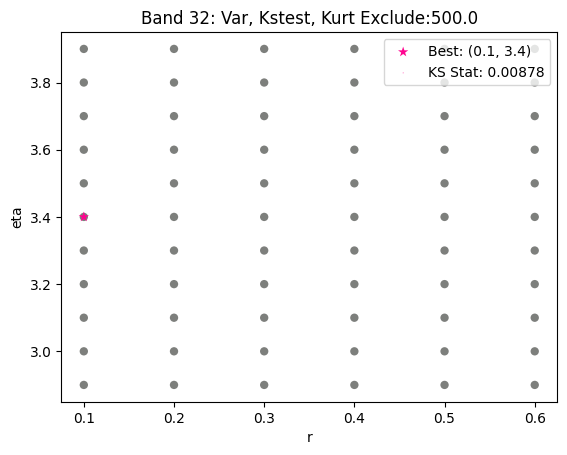

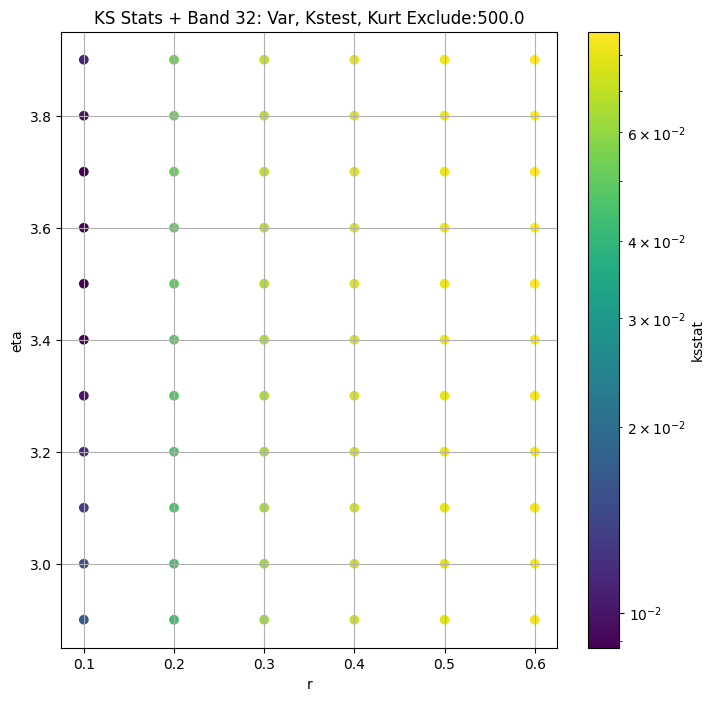

obs_var   var_lower    var_upper     obs_kurt  kurt_lower  \
band                                                                  
2     1690.463300  778.425800  4474.268600   1951.21090   93.389990   
5      925.186340  445.423340  2432.551000   1732.74070  102.459850   
8      286.479130  157.758420   630.313350    997.55035   76.816630   
11     254.842960   72.829560  1635.355600  13976.00800   62.877470   
14      74.946200   35.321682   283.324700   4449.84300   48.653390   
17      34.729362   17.269596   129.885730   4455.63230   42.402900   
20      15.656890    7.718547    51.575360   3024.86230   61.902660   
23       7.015059    2.579246    40.182514  11453.02000   71.847640   
26       4.446219    0.765977    42.104828  27543.82800   79.598564   
29       1.485536    0.097734    14.558654  38067.58200  100.885220   
32       0.048399    0.010321     0.300186  13939.49500   95.461980   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2      3809.4540        45000.0             0.006183        0.1          2.5   
5      3959.4731       117000.0             0.005385        0.1          2.5   
8      2699.5813       189000.0             0.004480        0.1          3.1   
11     8349.7330       495000.0             0.003599        0.1          3.5   
14     6157.9995      1134000.0             0.002984        0.1          3.7   
17     6093.3640      2574000.0             0.002845        0.1          3.4   
20     4879.5195      5967000.0             0.002774        0.1          3.3   
23     7815.2046     13887000.0             0.004336        0.1          3.2   
26     9199.3900     31968000.0             0.004770        0.1          2.2   
29     9678.4180     73701000.0             0.006696        0.1          1.8   
32     8480.3460     59634000.0             0.008780        0.1          3.4   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      1.441395e-14                   100.0          429.836120   
5      6.732665e-15                   350.0          200.773700   
8      7.915616e-16                   300.0           84.014370   
11     1.958911e-16                   250.0           44.661514   
14     7.526925e-17                   200.0           24.630728   
17     6.944719e-17                   150.0           13.149749   
20     3.248852e-17                   200.0            5.091034   
23     1.189379e-17                   250.0            1.536807   
26     2.991950e-17                   250.0            0.442577   
29     9.437417e-18                   300.0            0.050392   
32     2.522540e-20                   500.0            0.004776   

      kstest_stat_cutoff_0.05  
band                           
2                    0.006398  
5                    0.003969  
8                    0.003123  
11                   0.001930  
14                   0.001275  
17                   0.000846  
20                   0.000556  
23                   0.000364  
26                   0.000240  
29                   0.000158  
32                   0.000176

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


100%|██████████| 522/522 [00:01<00:00, 295.99it/s]


Finding Minimum after computing 522 CDFs
band 2, 100.0 + 100 = 200, ksstat: 0.009059551372339714, var: 349.8257751464844


100%|██████████| 522/522 [00:01<00:00, 285.72it/s]


Finding Minimum after computing 522 CDFs
band 2, 100.0 + 75 = 175, ksstat: 0.008043141740762816, var: 364.734619140625


100%|██████████| 522/522 [00:01<00:00, 300.78it/s]


Finding Minimum after computing 522 CDFs
band 2, 100.0 + 50 = 150, ksstat: 0.006769527572197287, var: 382.4712219238281


100%|██████████| 522/522 [00:01<00:00, 308.64it/s]


Finding Minimum after computing 522 CDFs
band 2, 100.0 + 25 = 125, ksstat: 0.005747138801043716, var: 403.5642395019531


100%|██████████| 522/522 [00:01<00:00, 305.67it/s]


Finding Minimum after computing 522 CDFs
band 2, 100.0 + 0 = 100, ksstat: 0.006183053503059033, var: 429.83612060546875


100%|██████████| 522/522 [00:01<00:00, 310.48it/s]


Finding Minimum after computing 522 CDFs
band 2, 100.0 + -25 = 75, ksstat: 0.006534123921685175, var: 469.132568359375


100%|██████████| 522/522 [00:01<00:00, 303.04it/s]


Finding Minimum after computing 522 CDFs
band 2, 100.0 + -50 = 50, ksstat: 0.00978148046062477, var: 538.2119140625


100%|██████████| 522/522 [00:01<00:00, 295.20it/s]


Finding Minimum after computing 522 CDFs
band 2, 100.0 + -75 = 25, ksstat: 0.01422562824508078, var: 670.6071166992188


100%|██████████| 522/522 [00:01<00:00, 296.58it/s]


Finding Minimum after computing 522 CDFs
band 2, 100.0 + -100 = 0, ksstat: 0.029811595145614565, var: 1690.4632568359375
Number of samples: 45000, Without approximation : 45000.0


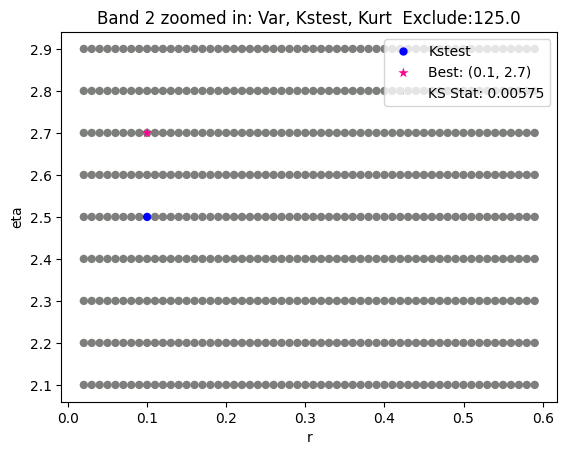

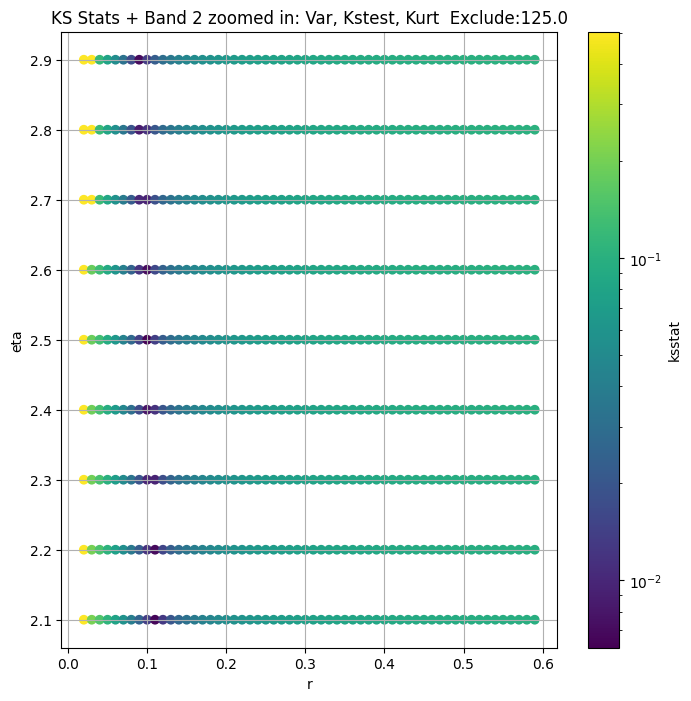

Band 5


100%|██████████| 522/522 [00:04<00:00, 125.12it/s]


Finding Minimum after computing 522 CDFs
band 5, 350.0 + 100 = 450, ksstat: 0.0065872582785699435, var: 182.04811096191406


100%|██████████| 522/522 [00:04<00:00, 121.05it/s]


Finding Minimum after computing 522 CDFs
band 5, 350.0 + 75 = 425, ksstat: 0.006300259599678311, var: 186.13099670410156


100%|██████████| 522/522 [00:04<00:00, 122.02it/s]


Finding Minimum after computing 522 CDFs
band 5, 350.0 + 50 = 400, ksstat: 0.005944705554738651, var: 190.58697509765625


100%|██████████| 522/522 [00:04<00:00, 129.19it/s]


Finding Minimum after computing 522 CDFs
band 5, 350.0 + 25 = 375, ksstat: 0.005674171665982685, var: 195.4313201904297


100%|██████████| 522/522 [00:04<00:00, 126.96it/s]


Finding Minimum after computing 522 CDFs
band 5, 350.0 + 0 = 350, ksstat: 0.005359697738554896, var: 200.77369689941406


100%|██████████| 522/522 [00:04<00:00, 126.65it/s]


Finding Minimum after computing 522 CDFs
band 5, 350.0 + -25 = 325, ksstat: 0.005108231070742437, var: 206.6225128173828


100%|██████████| 522/522 [00:04<00:00, 123.28it/s]


Finding Minimum after computing 522 CDFs
band 5, 350.0 + -50 = 300, ksstat: 0.005491704915761994, var: 212.97335815429688


100%|██████████| 522/522 [00:04<00:00, 126.13it/s]


Finding Minimum after computing 522 CDFs
band 5, 350.0 + -75 = 275, ksstat: 0.006370844460309, var: 220.12335205078125


100%|██████████| 522/522 [00:04<00:00, 125.19it/s]


Finding Minimum after computing 522 CDFs
band 5, 350.0 + -100 = 250, ksstat: 0.006808720913080615, var: 228.12123107910156
Number of samples: 100000, Without approximation : 117000.0


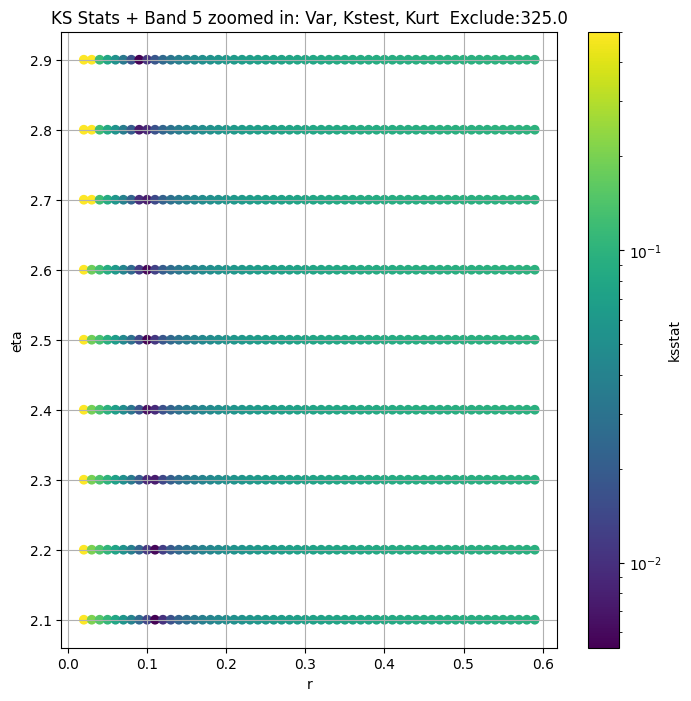

Band 8


100%|██████████| 522/522 [00:04<00:00, 122.19it/s]


Finding Minimum after computing 522 CDFs
band 8, 300.0 + 100 = 400, ksstat: 0.005655843166388341, var: 76.3740234375


100%|██████████| 522/522 [00:04<00:00, 122.41it/s]


Finding Minimum after computing 522 CDFs
band 8, 300.0 + 75 = 375, ksstat: 0.005362039446662914, var: 78.056396484375


100%|██████████| 522/522 [00:04<00:00, 121.03it/s]


Finding Minimum after computing 522 CDFs
band 8, 300.0 + 50 = 350, ksstat: 0.005066424883211407, var: 79.88394165039062


100%|██████████| 522/522 [00:04<00:00, 115.90it/s]


Finding Minimum after computing 522 CDFs
band 8, 300.0 + 25 = 325, ksstat: 0.004785545413798609, var: 81.8576431274414


100%|██████████| 522/522 [00:04<00:00, 116.79it/s]


Finding Minimum after computing 522 CDFs
band 8, 300.0 + 0 = 300, ksstat: 0.0044803650922471405, var: 84.01437377929688


100%|██████████| 522/522 [00:04<00:00, 120.03it/s]


Finding Minimum after computing 522 CDFs
band 8, 300.0 + -25 = 275, ksstat: 0.0041589093668933375, var: 86.44074249267578


100%|██████████| 522/522 [00:04<00:00, 114.77it/s]


Finding Minimum after computing 522 CDFs
band 8, 300.0 + -50 = 250, ksstat: 0.005009776508073632, var: 89.167236328125


100%|██████████| 522/522 [00:04<00:00, 117.65it/s]


Finding Minimum after computing 522 CDFs
band 8, 300.0 + -75 = 225, ksstat: 0.005349839390021649, var: 92.2422866821289


100%|██████████| 522/522 [00:04<00:00, 118.05it/s]


Finding Minimum after computing 522 CDFs
band 8, 300.0 + -100 = 200, ksstat: 0.0068025459247749165, var: 95.75594329833984
Number of samples: 100000, Without approximation : 189000.0


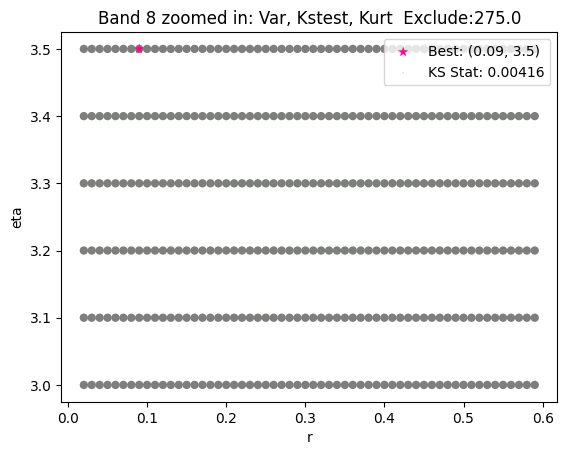

Band 11


100%|██████████| 522/522 [00:04<00:00, 115.60it/s]


Finding Minimum after computing 522 CDFs
band 11, 250.0 + 100 = 350, ksstat: 0.004909811202691516, var: 40.6948127746582


100%|██████████| 522/522 [00:04<00:00, 121.04it/s]


Finding Minimum after computing 522 CDFs
band 11, 250.0 + 75 = 325, ksstat: 0.004565842822705113, var: 41.54634094238281


100%|██████████| 522/522 [00:04<00:00, 129.99it/s]


Finding Minimum after computing 522 CDFs
band 11, 250.0 + 50 = 300, ksstat: 0.004204038730081572, var: 42.47955322265625


100%|██████████| 522/522 [00:04<00:00, 118.39it/s]


Finding Minimum after computing 522 CDFs
band 11, 250.0 + 25 = 275, ksstat: 0.003897175669643538, var: 43.511932373046875


100%|██████████| 522/522 [00:04<00:00, 119.96it/s]


Finding Minimum after computing 522 CDFs
band 11, 250.0 + 0 = 250, ksstat: 0.0035991142652927136, var: 44.66151428222656


100%|██████████| 522/522 [00:04<00:00, 118.64it/s]


Finding Minimum after computing 522 CDFs
band 11, 250.0 + -25 = 225, ksstat: 0.003641373170307216, var: 45.96515655517578


100%|██████████| 522/522 [00:04<00:00, 129.59it/s]


Finding Minimum after computing 522 CDFs
band 11, 250.0 + -50 = 200, ksstat: 0.004239538588061198, var: 47.4556770324707


100%|██████████| 522/522 [00:04<00:00, 124.04it/s]


Finding Minimum after computing 522 CDFs
band 11, 250.0 + -75 = 175, ksstat: 0.0053060492181164765, var: 49.18811798095703


100%|██████████| 522/522 [00:04<00:00, 127.38it/s]


Finding Minimum after computing 522 CDFs
band 11, 250.0 + -100 = 150, ksstat: 0.00634446332337632, var: 51.20603942871094
Number of samples: 100000, Without approximation : 495000.0


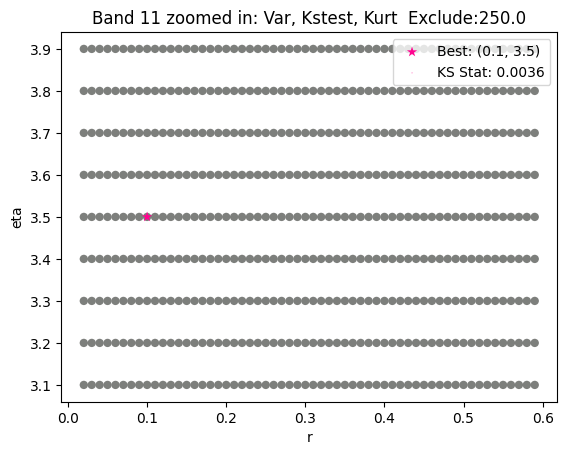

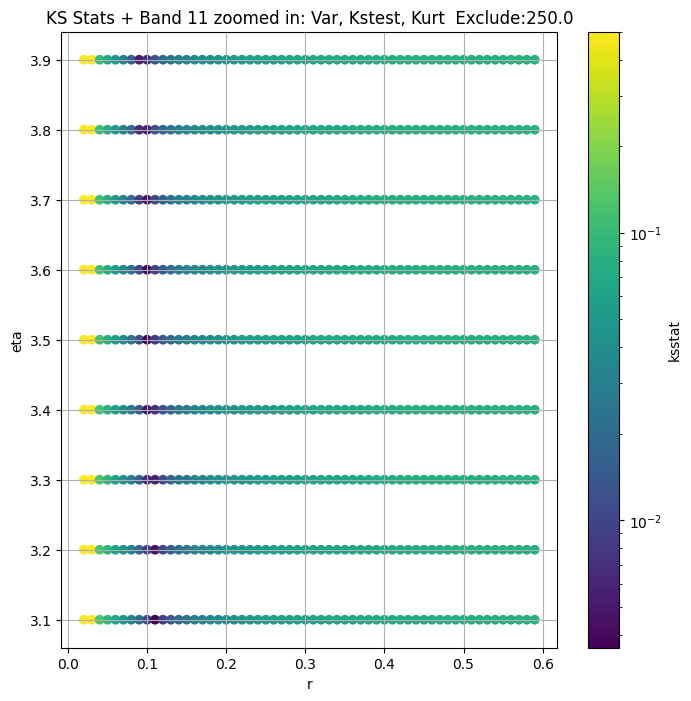

Band 14


100%|██████████| 522/522 [00:04<00:00, 117.55it/s]


Finding Minimum after computing 522 CDFs
band 14, 200.0 + 100 = 300, ksstat: 0.004370506479285385, var: 22.380788803100586


100%|██████████| 522/522 [00:04<00:00, 118.06it/s]


Finding Minimum after computing 522 CDFs
band 14, 200.0 + 75 = 275, ksstat: 0.003983535081596101, var: 22.85468292236328


100%|██████████| 522/522 [00:04<00:00, 122.41it/s]


Finding Minimum after computing 522 CDFs
band 14, 200.0 + 50 = 250, ksstat: 0.003606530510756767, var: 23.381010055541992


100%|██████████| 522/522 [00:04<00:00, 126.25it/s]


Finding Minimum after computing 522 CDFs
band 14, 200.0 + 25 = 225, ksstat: 0.0032697301454576166, var: 23.968673706054688


100%|██████████| 522/522 [00:03<00:00, 131.30it/s]


Finding Minimum after computing 522 CDFs
band 14, 200.0 + 0 = 200, ksstat: 0.0029842795191428184, var: 24.630727767944336


100%|██████████| 522/522 [00:04<00:00, 120.73it/s]


Finding Minimum after computing 522 CDFs
band 14, 200.0 + -25 = 175, ksstat: 0.003185522127331461, var: 25.389904022216797


100%|██████████| 522/522 [00:04<00:00, 118.46it/s]


Finding Minimum after computing 522 CDFs
band 14, 200.0 + -50 = 150, ksstat: 0.004196070171928606, var: 26.27402114868164


100%|██████████| 522/522 [00:04<00:00, 120.68it/s]


Finding Minimum after computing 522 CDFs
band 14, 200.0 + -75 = 125, ksstat: 0.005474280660229425, var: 27.324617385864258


100%|██████████| 522/522 [00:04<00:00, 116.58it/s]


Finding Minimum after computing 522 CDFs
band 14, 200.0 + -100 = 100, ksstat: 0.0063539449097534395, var: 28.613719940185547
Number of samples: 100000, Without approximation : 1134000.0


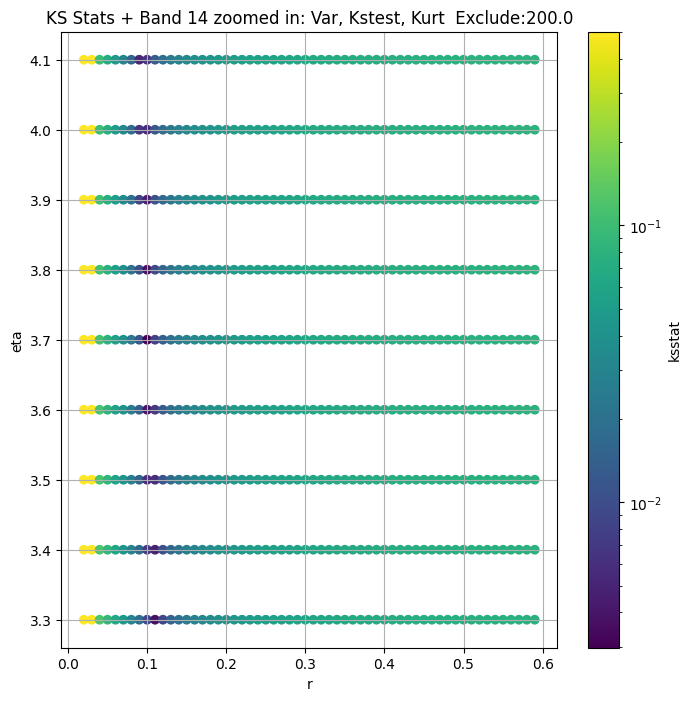

Band 17


100%|██████████| 522/522 [00:03<00:00, 136.81it/s]


Finding Minimum after computing 522 CDFs
band 17, 150.0 + 100 = 250, ksstat: 0.003538795096533055, var: 11.793085098266602


100%|██████████| 522/522 [00:04<00:00, 130.42it/s]


Finding Minimum after computing 522 CDFs
band 17, 150.0 + 75 = 225, ksstat: 0.0032236843431871845, var: 12.06840991973877


100%|██████████| 522/522 [00:04<00:00, 115.92it/s]


Finding Minimum after computing 522 CDFs
band 17, 150.0 + 50 = 200, ksstat: 0.0029035507477828534, var: 12.379281997680664


100%|██████████| 522/522 [00:04<00:00, 122.19it/s]


Finding Minimum after computing 522 CDFs
band 17, 150.0 + 25 = 175, ksstat: 0.002641596489521019, var: 12.734528541564941


100%|██████████| 522/522 [00:04<00:00, 123.93it/s]


Finding Minimum after computing 522 CDFs
band 17, 150.0 + 0 = 150, ksstat: 0.0028452465153013806, var: 13.149748802185059


100%|██████████| 522/522 [00:04<00:00, 120.74it/s]


Finding Minimum after computing 522 CDFs
band 17, 150.0 + -25 = 125, ksstat: 0.0038163826592517713, var: 13.642854690551758


100%|██████████| 522/522 [00:04<00:00, 119.53it/s]


Finding Minimum after computing 522 CDFs
band 17, 150.0 + -50 = 100, ksstat: 0.004895796238944761, var: 14.250858306884766


100%|██████████| 522/522 [00:04<00:00, 118.16it/s]


Finding Minimum after computing 522 CDFs
band 17, 150.0 + -75 = 75, ksstat: 0.006653168475885263, var: 15.033866882324219


100%|██████████| 522/522 [00:04<00:00, 117.93it/s]


Finding Minimum after computing 522 CDFs
band 17, 150.0 + -100 = 50, ksstat: 0.007803005411370356, var: 16.12587547302246
Number of samples: 100000, Without approximation : 2574000.0


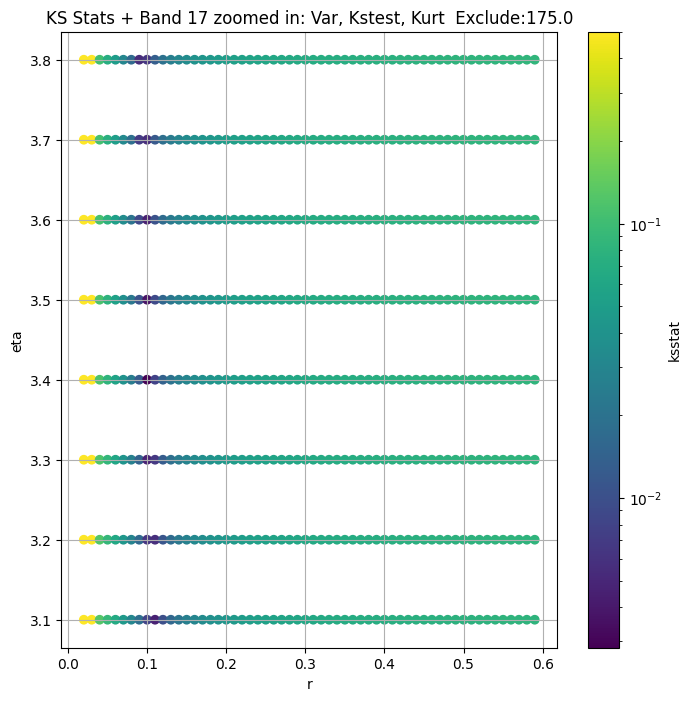

Band 20


100%|██████████| 522/522 [00:04<00:00, 119.58it/s]


Finding Minimum after computing 522 CDFs
band 20, 200.0 + 100 = 300, ksstat: 0.004316269999989863, var: 4.599359512329102


100%|██████████| 522/522 [00:04<00:00, 122.25it/s]


Finding Minimum after computing 522 CDFs
band 20, 200.0 + 75 = 275, ksstat: 0.0038450110133773936, var: 4.701315402984619


100%|██████████| 522/522 [00:04<00:00, 115.38it/s]


Finding Minimum after computing 522 CDFs
band 20, 200.0 + 50 = 250, ksstat: 0.00341432240786968, var: 4.814970016479492


100%|██████████| 522/522 [00:04<00:00, 118.90it/s]


Finding Minimum after computing 522 CDFs
band 20, 200.0 + 25 = 225, ksstat: 0.003063688042646587, var: 4.94354248046875


100%|██████████| 522/522 [00:04<00:00, 122.73it/s]


Finding Minimum after computing 522 CDFs
band 20, 200.0 + 0 = 200, ksstat: 0.002773840563078297, var: 5.091033935546875


100%|██████████| 522/522 [00:04<00:00, 119.91it/s]


Finding Minimum after computing 522 CDFs
band 20, 200.0 + -25 = 175, ksstat: 0.0024920617604859887, var: 5.262650012969971


100%|██████████| 522/522 [00:04<00:00, 118.85it/s]


Finding Minimum after computing 522 CDFs
band 20, 200.0 + -50 = 150, ksstat: 0.0032933068309711766, var: 5.466999053955078


100%|██████████| 522/522 [00:04<00:00, 119.18it/s]


Finding Minimum after computing 522 CDFs
band 20, 200.0 + -75 = 125, ksstat: 0.004583751270563874, var: 5.717691898345947


100%|██████████| 522/522 [00:04<00:00, 123.69it/s]


Finding Minimum after computing 522 CDFs
band 20, 200.0 + -100 = 100, ksstat: 0.00570785055927886, var: 6.0330047607421875
Number of samples: 100000, Without approximation : 5967000.0


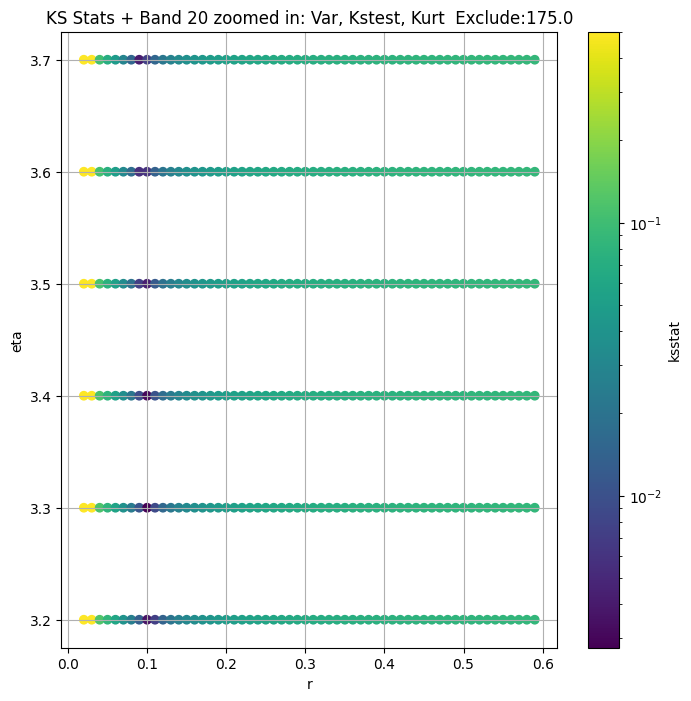

Band 23


100%|██████████| 522/522 [00:04<00:00, 121.30it/s]


Finding Minimum after computing 522 CDFs
band 23, 250.0 + 100 = 350, ksstat: 0.005640959895641284, var: 1.4063867330551147


100%|██████████| 522/522 [00:04<00:00, 126.15it/s]


Finding Minimum after computing 522 CDFs
band 23, 250.0 + 75 = 325, ksstat: 0.00521224110515528, var: 1.4344767332077026


100%|██████████| 522/522 [00:04<00:00, 121.48it/s]


Finding Minimum after computing 522 CDFs
band 23, 250.0 + 50 = 300, ksstat: 0.004801578058636347, var: 1.4651505947113037


100%|██████████| 522/522 [00:04<00:00, 118.78it/s]


Finding Minimum after computing 522 CDFs
band 23, 250.0 + 25 = 275, ksstat: 0.004388808152279267, var: 1.4990079402923584


100%|██████████| 522/522 [00:04<00:00, 118.04it/s]


Finding Minimum after computing 522 CDFs
band 23, 250.0 + 0 = 250, ksstat: 0.004336103901898647, var: 1.5368072986602783


100%|██████████| 522/522 [00:04<00:00, 124.92it/s]


Finding Minimum after computing 522 CDFs
band 23, 250.0 + -25 = 225, ksstat: 0.00457252248534179, var: 1.5795228481292725


100%|██████████| 522/522 [00:04<00:00, 118.54it/s]


Finding Minimum after computing 522 CDFs
band 23, 250.0 + -50 = 200, ksstat: 0.005253255291749914, var: 1.628584861755371


100%|██████████| 522/522 [00:04<00:00, 122.33it/s]


Finding Minimum after computing 522 CDFs
band 23, 250.0 + -75 = 175, ksstat: 0.006064807428398877, var: 1.6861540079116821


100%|██████████| 522/522 [00:04<00:00, 121.87it/s]


Finding Minimum after computing 522 CDFs
band 23, 250.0 + -100 = 150, ksstat: 0.006646477918277771, var: 1.7553406953811646
Number of samples: 100000, Without approximation : 13887000.0


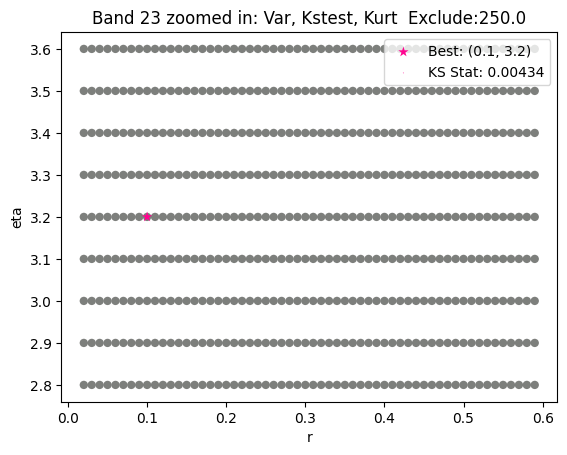

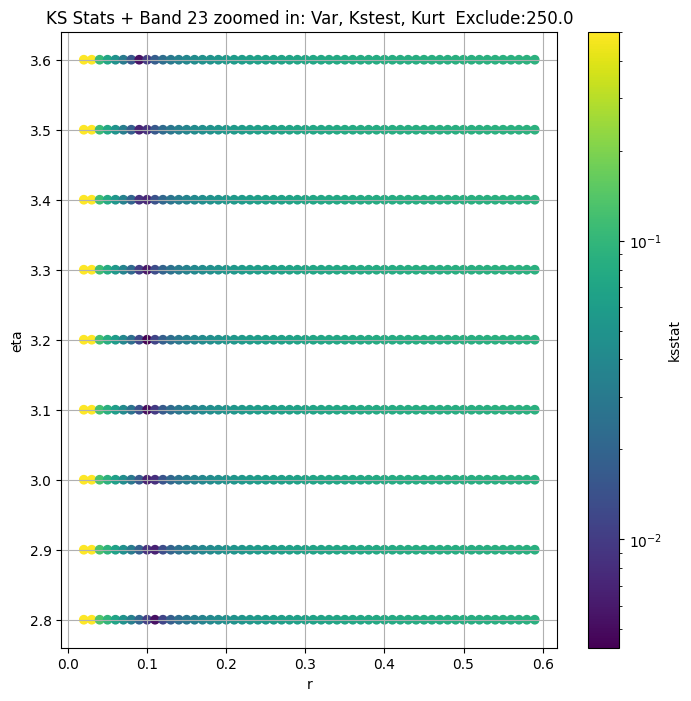

Band 26


100%|██████████| 522/522 [00:04<00:00, 122.48it/s]


Finding Minimum after computing 522 CDFs
band 26, 250.0 + 100 = 350, ksstat: 0.0061812120149790095, var: 0.40146541595458984


100%|██████████| 522/522 [00:04<00:00, 117.70it/s]


Finding Minimum after computing 522 CDFs
band 26, 250.0 + 75 = 325, ksstat: 0.005738773635204253, var: 0.4103313982486725


100%|██████████| 522/522 [00:04<00:00, 118.30it/s]


Finding Minimum after computing 522 CDFs
band 26, 250.0 + 50 = 300, ksstat: 0.00531500695583198, var: 0.42001643776893616


100%|██████████| 522/522 [00:04<00:00, 118.88it/s]


Finding Minimum after computing 522 CDFs
band 26, 250.0 + 25 = 275, ksstat: 0.004842318246070065, var: 0.4306914508342743


100%|██████████| 522/522 [00:04<00:00, 121.36it/s]


Finding Minimum after computing 522 CDFs
band 26, 250.0 + 0 = 250, ksstat: 0.004692179143083286, var: 0.4425770342350006


100%|██████████| 522/522 [00:04<00:00, 122.23it/s]


Finding Minimum after computing 522 CDFs
band 26, 250.0 + -25 = 225, ksstat: 0.004508483528764873, var: 0.45596441626548767


100%|██████████| 522/522 [00:04<00:00, 119.19it/s]


Finding Minimum after computing 522 CDFs
band 26, 250.0 + -50 = 200, ksstat: 0.005166906303184171, var: 0.471293568611145


100%|██████████| 522/522 [00:04<00:00, 123.34it/s]


Finding Minimum after computing 522 CDFs
band 26, 250.0 + -75 = 175, ksstat: 0.006069164517080283, var: 0.48917001485824585


100%|██████████| 522/522 [00:04<00:00, 123.46it/s]


Finding Minimum after computing 522 CDFs
band 26, 250.0 + -100 = 150, ksstat: 0.006993171388797514, var: 0.5105496048927307
Number of samples: 100000, Without approximation : 31968000.0


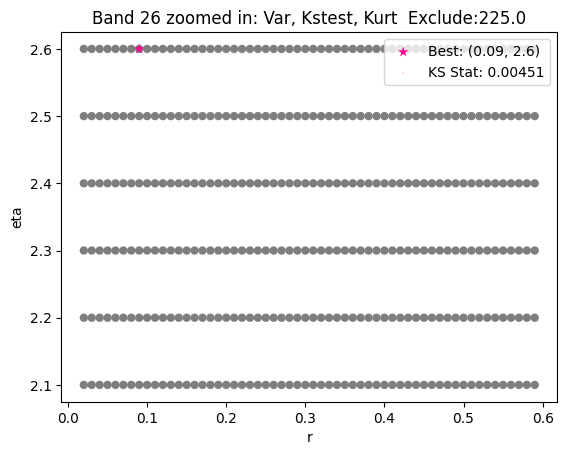

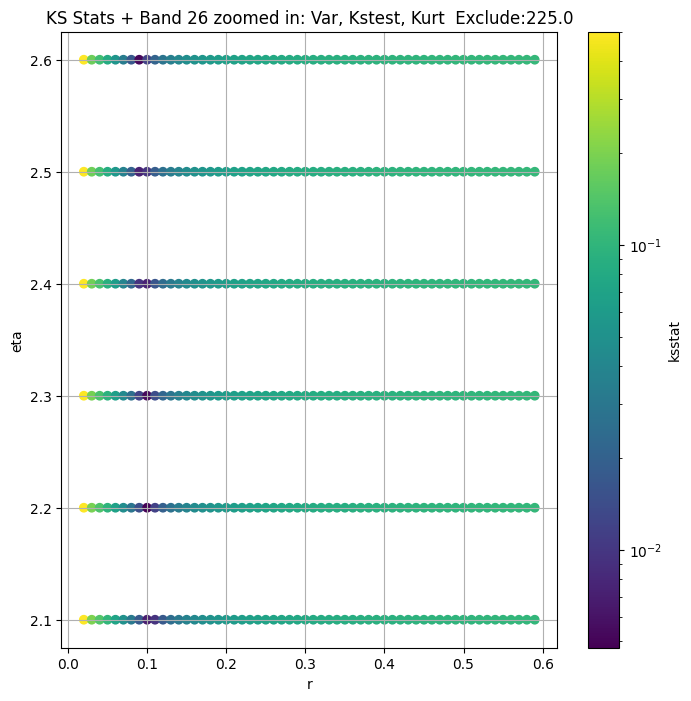

Band 29


100%|██████████| 580/580 [00:04<00:00, 119.64it/s]


Finding Minimum after computing 580 CDFs
band 29, 300.0 + 100 = 400, ksstat: 0.008381033868962273, var: 0.046149905771017075


100%|██████████| 580/580 [00:04<00:00, 122.64it/s]


Finding Minimum after computing 580 CDFs
band 29, 300.0 + 75 = 375, ksstat: 0.007852009555504136, var: 0.047089602798223495


100%|██████████| 580/580 [00:04<00:00, 120.00it/s]


Finding Minimum after computing 580 CDFs
band 29, 300.0 + 50 = 350, ksstat: 0.007545997382164882, var: 0.048100776970386505


100%|██████████| 580/580 [00:04<00:00, 124.67it/s]


Finding Minimum after computing 580 CDFs
band 29, 300.0 + 25 = 325, ksstat: 0.007144435298503171, var: 0.04919634759426117


100%|██████████| 580/580 [00:04<00:00, 125.67it/s]


Finding Minimum after computing 580 CDFs
band 29, 300.0 + 0 = 300, ksstat: 0.006696383952246587, var: 0.05039177089929581


100%|██████████| 580/580 [00:04<00:00, 122.01it/s]


Finding Minimum after computing 580 CDFs
band 29, 300.0 + -25 = 275, ksstat: 0.0064292344524385925, var: 0.05170730873942375


100%|██████████| 580/580 [00:04<00:00, 125.75it/s]


Finding Minimum after computing 580 CDFs
band 29, 300.0 + -50 = 250, ksstat: 0.007541829612068174, var: 0.053170982748270035


100%|██████████| 580/580 [00:04<00:00, 126.53it/s]


Finding Minimum after computing 580 CDFs
band 29, 300.0 + -75 = 225, ksstat: 0.007326526068982986, var: 0.05482332035899162


100%|██████████| 580/580 [00:04<00:00, 125.54it/s]


Finding Minimum after computing 580 CDFs
band 29, 300.0 + -100 = 200, ksstat: 0.007732447372362783, var: 0.056719280779361725
Number of samples: 100000, Without approximation : 73701000.0


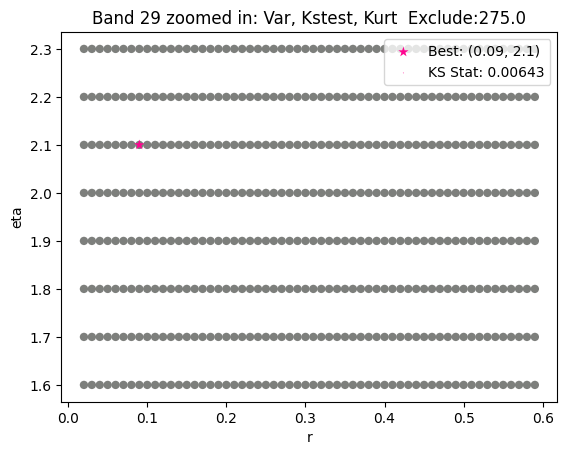

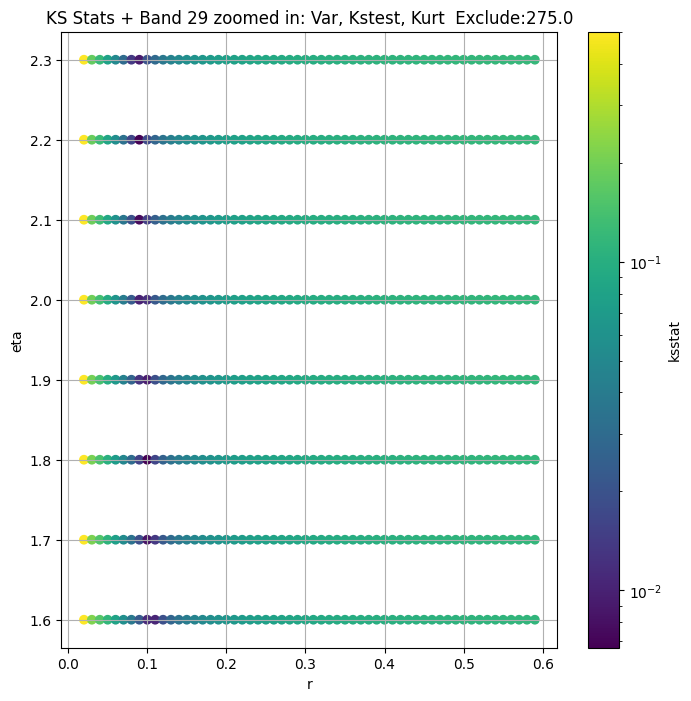

Band 32


100%|██████████| 522/522 [00:04<00:00, 126.12it/s]


Finding Minimum after computing 522 CDFs
band 32, 500.0 + 100 = 600, ksstat: 0.010038916375927649, var: 0.0045059300027787685


100%|██████████| 522/522 [00:04<00:00, 124.50it/s]


Finding Minimum after computing 522 CDFs
band 32, 500.0 + 75 = 575, ksstat: 0.009724156151549358, var: 0.004569155629724264


100%|██████████| 522/522 [00:04<00:00, 120.80it/s]


Finding Minimum after computing 522 CDFs
band 32, 500.0 + 50 = 550, ksstat: 0.009398052883598663, var: 0.004635130055248737


100%|██████████| 522/522 [00:04<00:00, 123.07it/s]


Finding Minimum after computing 522 CDFs
band 32, 500.0 + 25 = 525, ksstat: 0.009073397087317536, var: 0.004704104270786047


100%|██████████| 522/522 [00:04<00:00, 124.94it/s]


Finding Minimum after computing 522 CDFs
band 32, 500.0 + 0 = 500, ksstat: 0.00874730920149103, var: 0.004776402376592159


100%|██████████| 522/522 [00:04<00:00, 128.33it/s]


Finding Minimum after computing 522 CDFs
band 32, 500.0 + -25 = 475, ksstat: 0.008415571308536814, var: 0.004852393642067909


100%|██████████| 522/522 [00:04<00:00, 124.28it/s]


Finding Minimum after computing 522 CDFs
band 32, 500.0 + -50 = 450, ksstat: 0.008104546430493135, var: 0.004932455252856016


100%|██████████| 522/522 [00:04<00:00, 124.39it/s]


Finding Minimum after computing 522 CDFs
band 32, 500.0 + -75 = 425, ksstat: 0.007814844686975797, var: 0.005017096176743507


100%|██████████| 522/522 [00:04<00:00, 119.76it/s]


Finding Minimum after computing 522 CDFs
band 32, 500.0 + -100 = 400, ksstat: 0.007971906471656798, var: 0.005106927361339331
Number of samples: 100000, Without approximation : 59634000.0


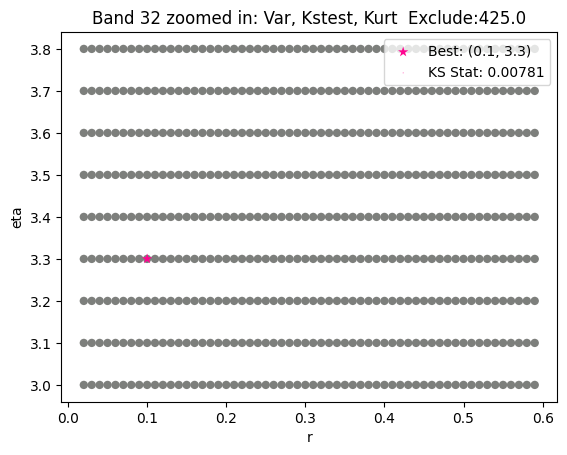

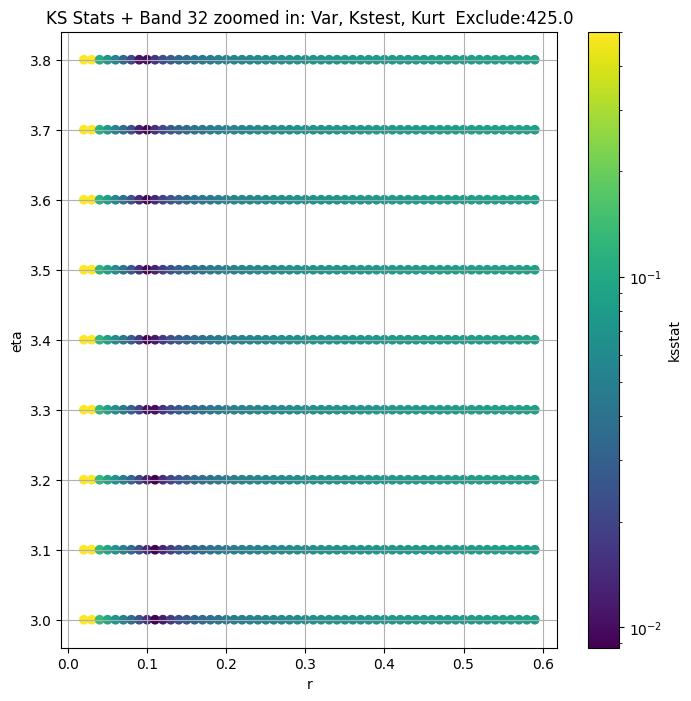

obs_var   var_lower    var_upper     obs_kurt  kurt_lower  \
band                                                                  
2     1690.463300  778.425800  4474.268600   1951.21090   93.389990   
5      925.186340  445.423340  2432.551000   1732.74070  102.459850   
8      286.479130  157.758420   630.313350    997.55035   76.816630   
11     254.842960   72.829560  1635.355600  13976.00800   62.877470   
14      74.946200   35.321682   283.324700   4449.84300   48.653390   
17      34.729362   17.269596   129.885730   4455.63230   42.402900   
20      15.656890    7.718547    51.575360   3024.86230   61.902660   
23       7.015059    2.579246    40.182514  11453.02000   71.847640   
26       4.446219    0.765977    42.104828  27543.82800   79.598564   
29       1.485536    0.097734    14.558654  38067.58200  100.885220   
32       0.048399    0.010321     0.300186  13939.49500   95.461980   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2      3809.4540        45000.0             0.006183        0.1          2.5   
5      3959.4731       117000.0             0.005385        0.1          2.5   
8      2699.5813       189000.0             0.004480        0.1          3.1   
11     8349.7330       495000.0             0.003599        0.1          3.5   
14     6157.9995      1134000.0             0.002984        0.1          3.7   
17     6093.3640      2574000.0             0.002845        0.1          3.4   
20     4879.5195      5967000.0             0.002774        0.1          3.3   
23     7815.2046     13887000.0             0.004336        0.1          3.2   
26     9199.3900     31968000.0             0.004770        0.1          2.2   
29     9678.4180     73701000.0             0.006696        0.1          1.8   
32     8480.3460     59634000.0             0.008780        0.1          3.4   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      1.441395e-14                   100.0          403.564240   
5      6.732665e-15                   350.0          206.622513   
8      7.915616e-16                   300.0           86.440742   
11     1.958911e-16                   250.0           44.661514   
14     7.526925e-17                   200.0           24.630728   
17     6.944719e-17                   150.0           12.734529   
20     3.248852e-17                   200.0            5.262650   
23     1.189379e-17                   250.0            1.536807   
26     2.991950e-17                   250.0            0.455964   
29     9.437417e-18                   300.0            0.051707   
32     2.522540e-20                   500.0            0.005017   

      kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
band                                                                
2                    0.006398          0.005747    0.10       2.7   
5                    0.003969          0.005108    0.10       2.4   
8                    0.003123          0.004159    0.09       3.5   
11                   0.001930          0.003599    0.10       3.5   
14                   0.001275          0.002984    0.10       3.7   
17                   0.000846          0.002642    0.10       3.6   
20                   0.000556          0.002492    0.09       3.7   
23                   0.000364          0.004336    0.10       3.2   
26                   0.000240          0.004508    0.09       2.6   
29                   0.000158          0.006429    0.09       2.1   
32                   0.000176          0.007815    0.10       3.3   

        best_scale  best_exclude_cutoff  n_pval_0.05  
band                                                  
2     8.703552e-15                125.0        56952  
5     8.705412e-15                325.0        74038  
8     1.371833e-18                275.0       106312  


In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

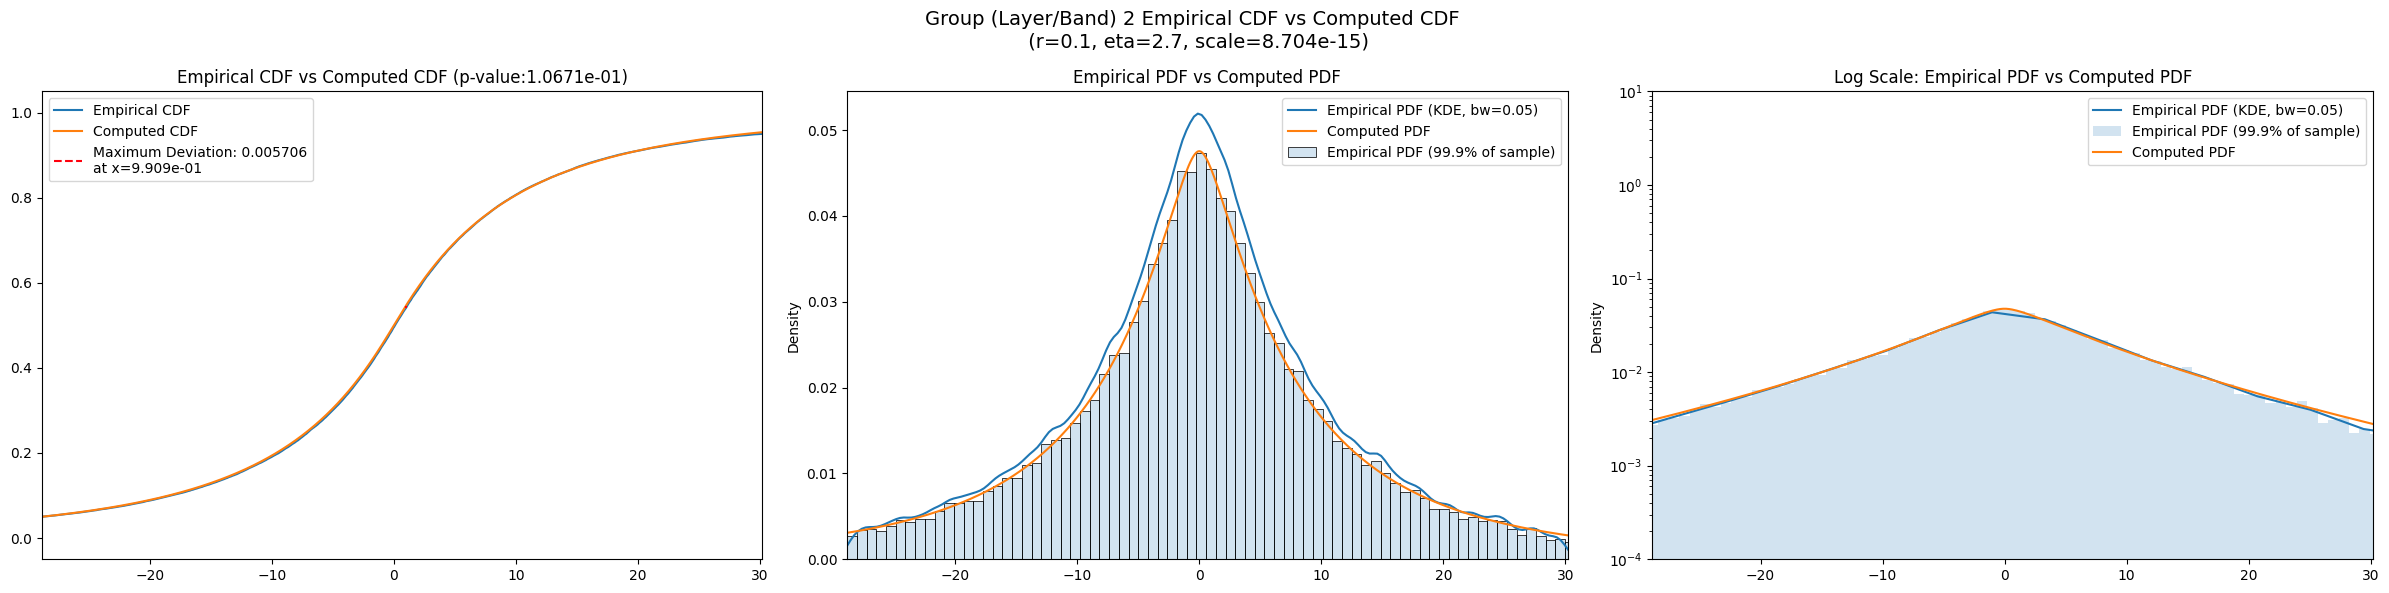

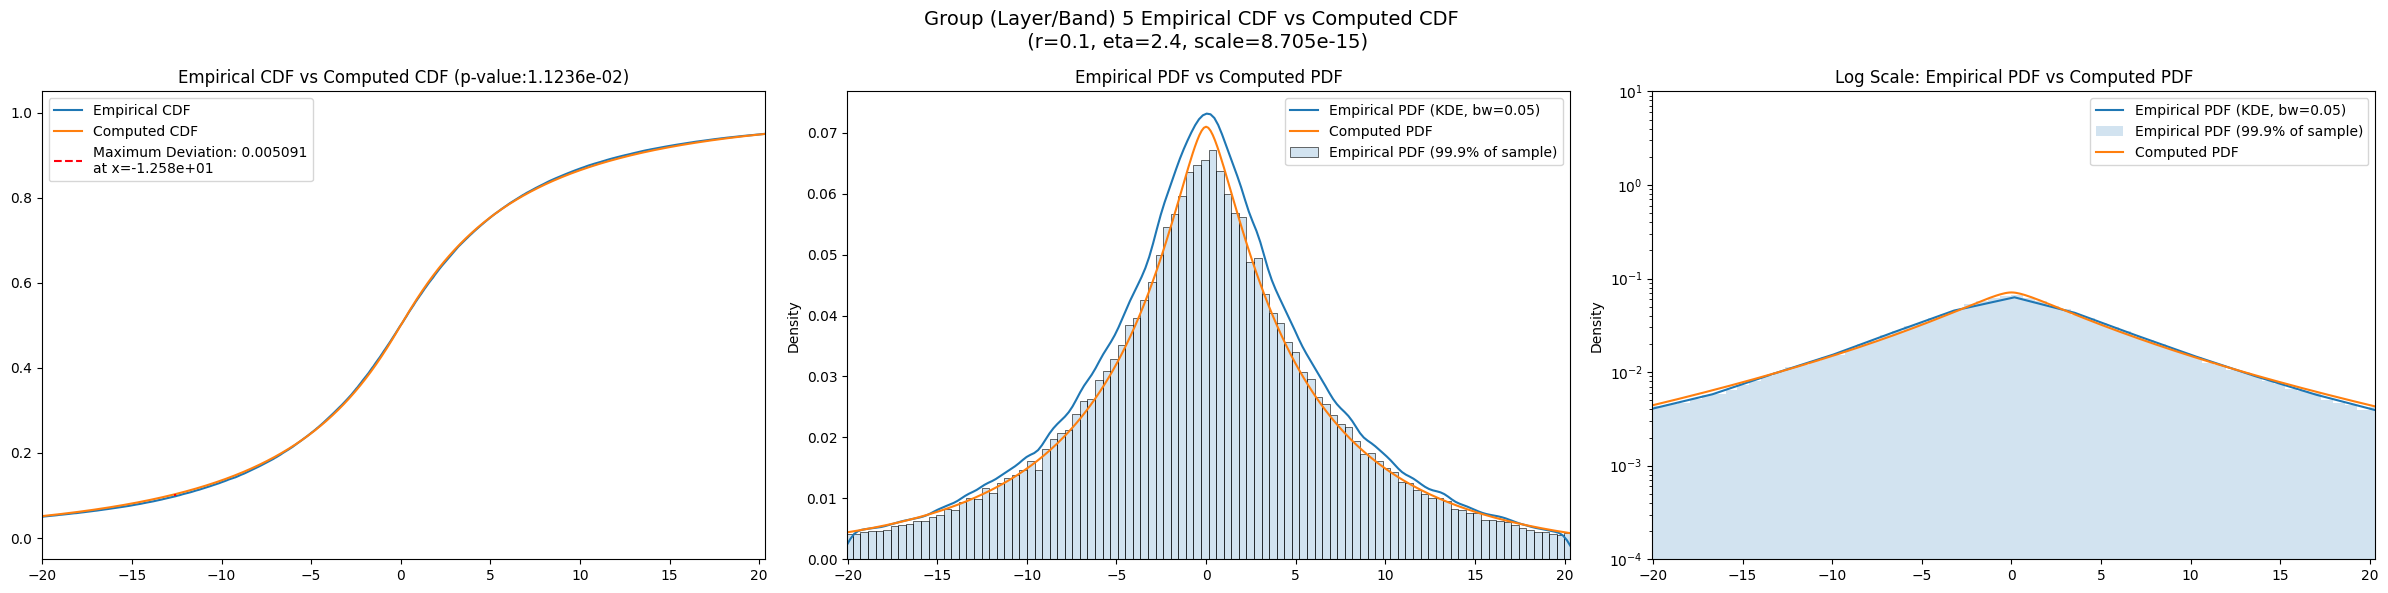

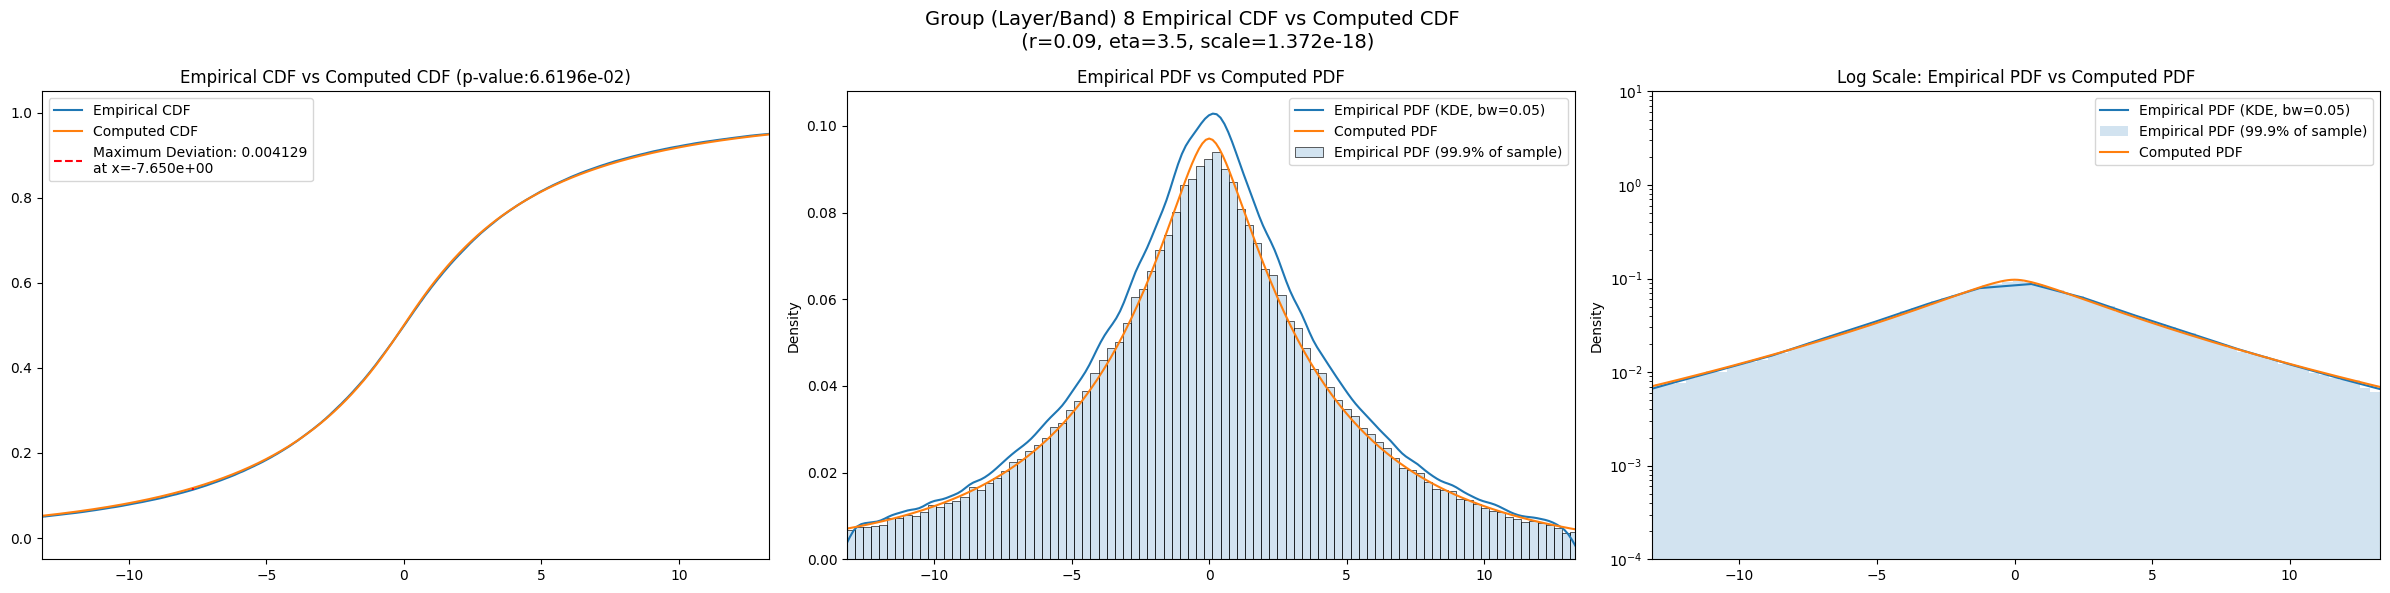

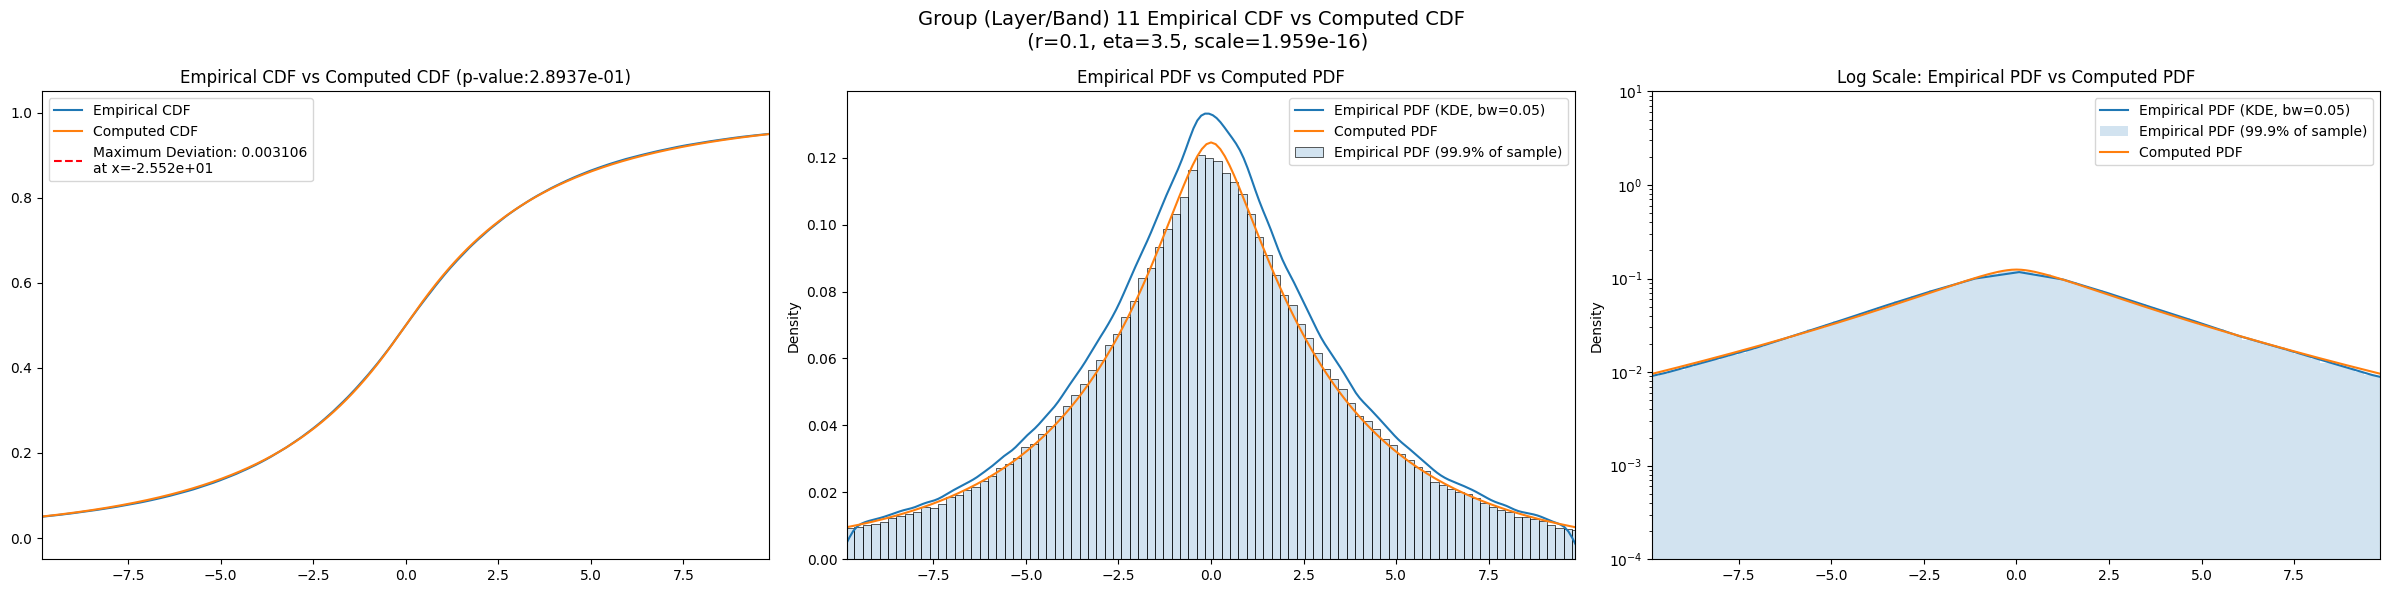

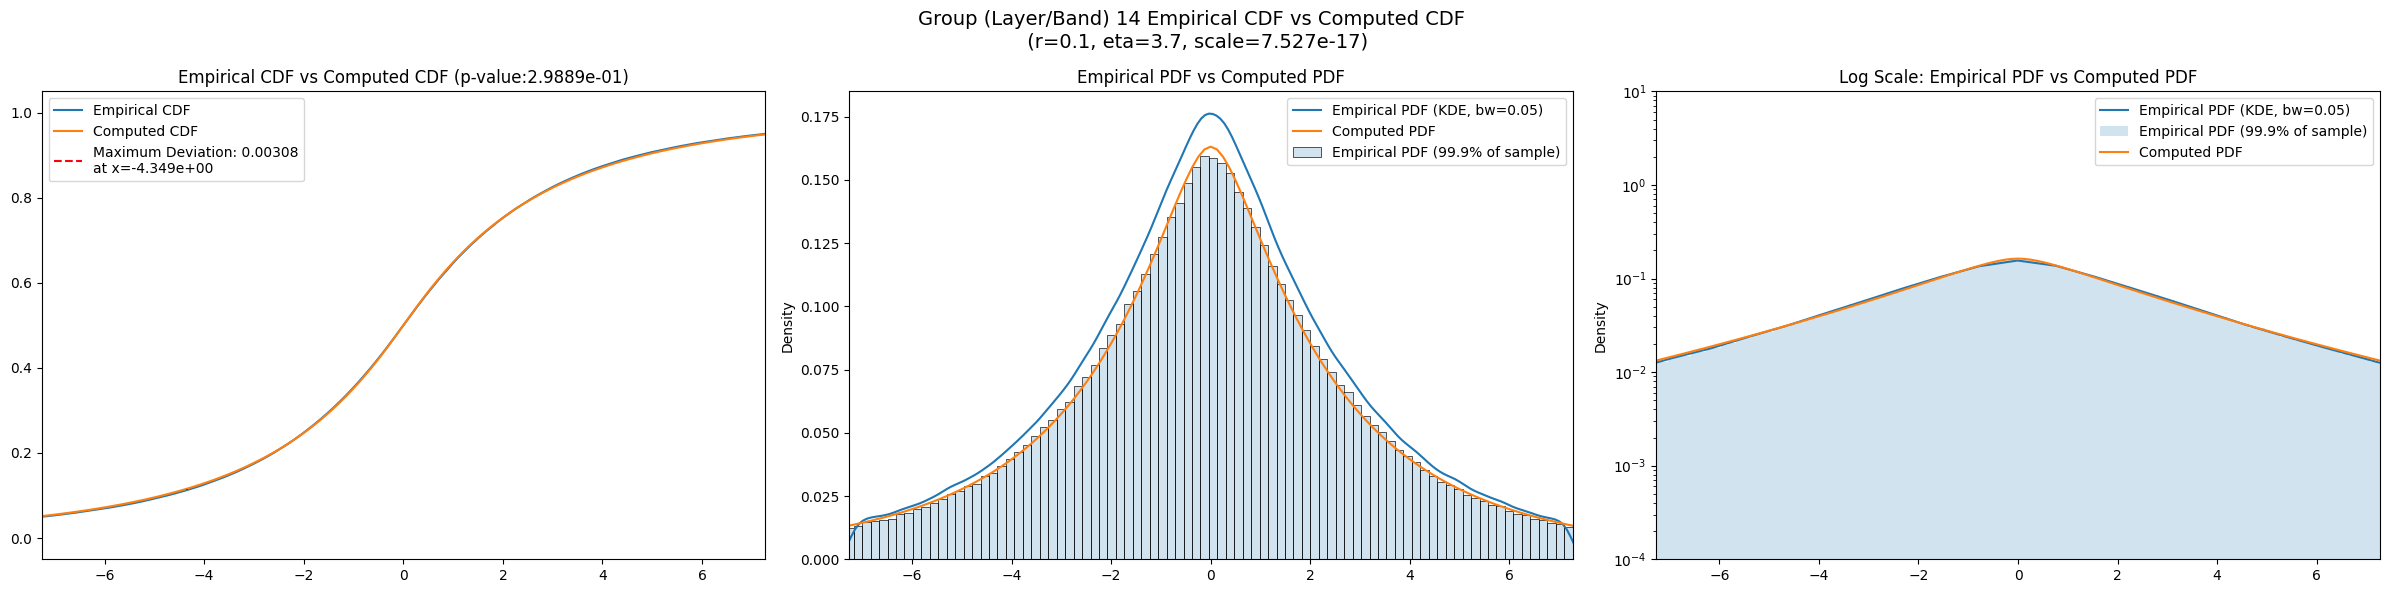

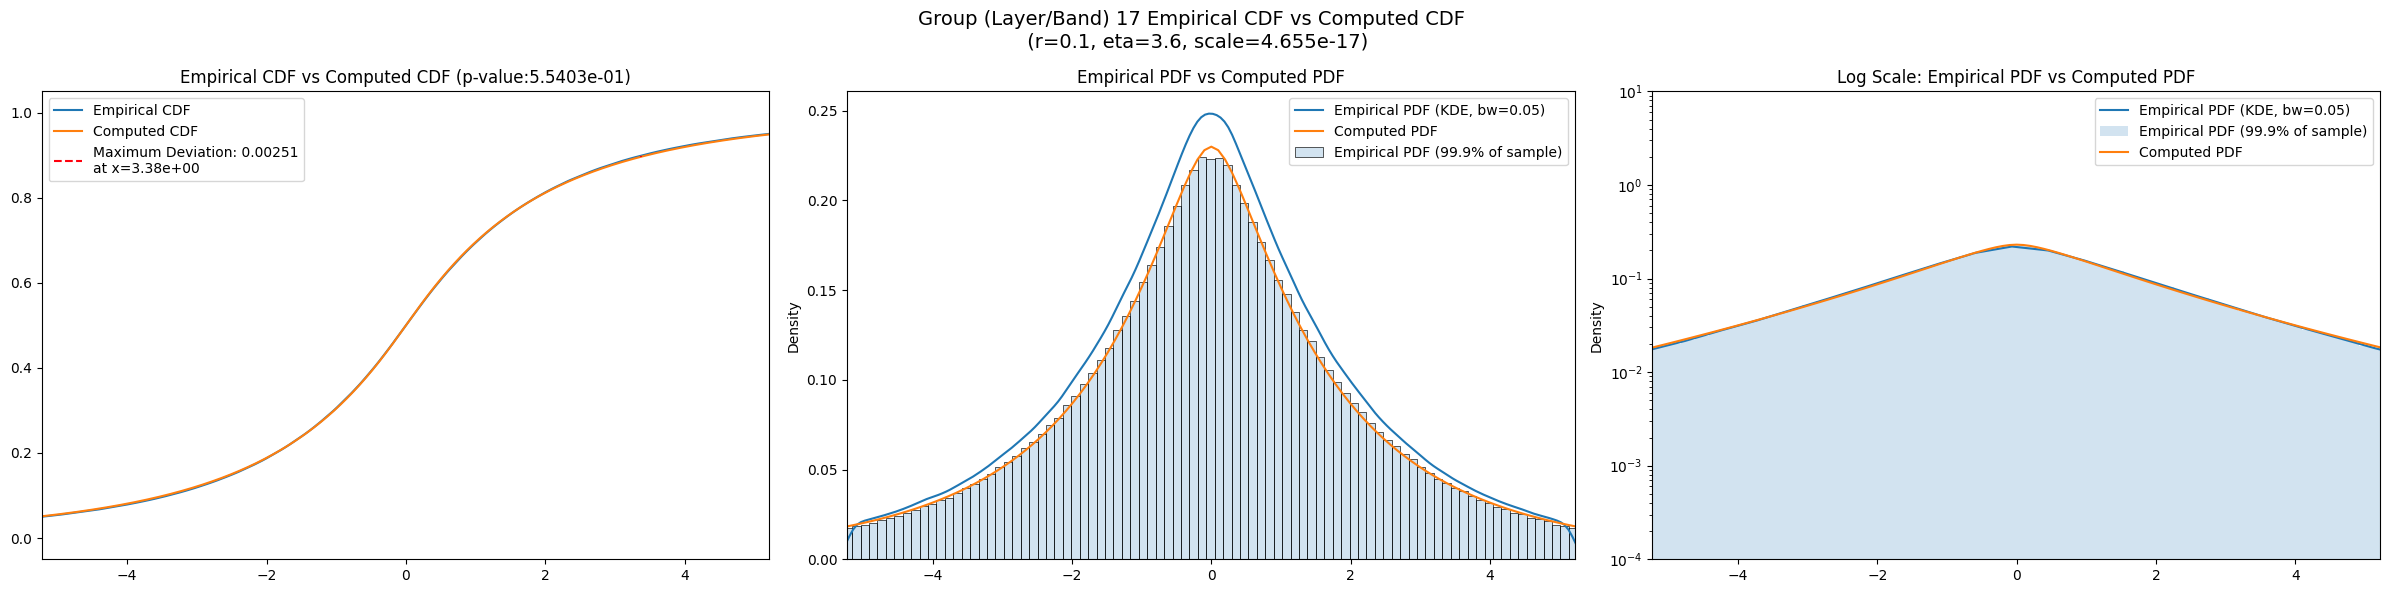

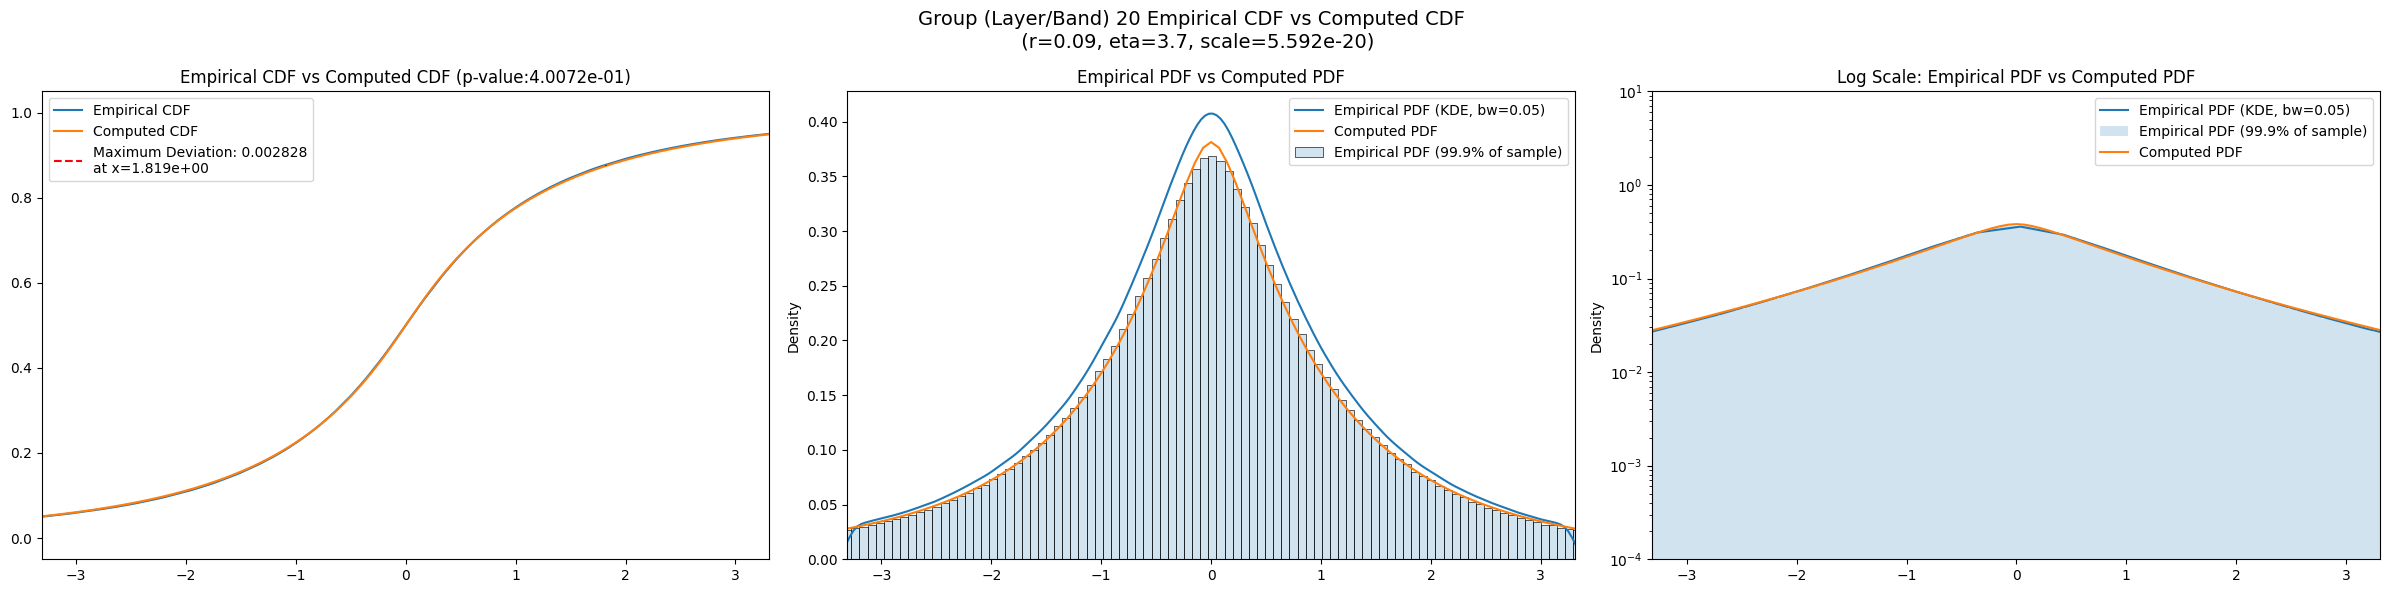

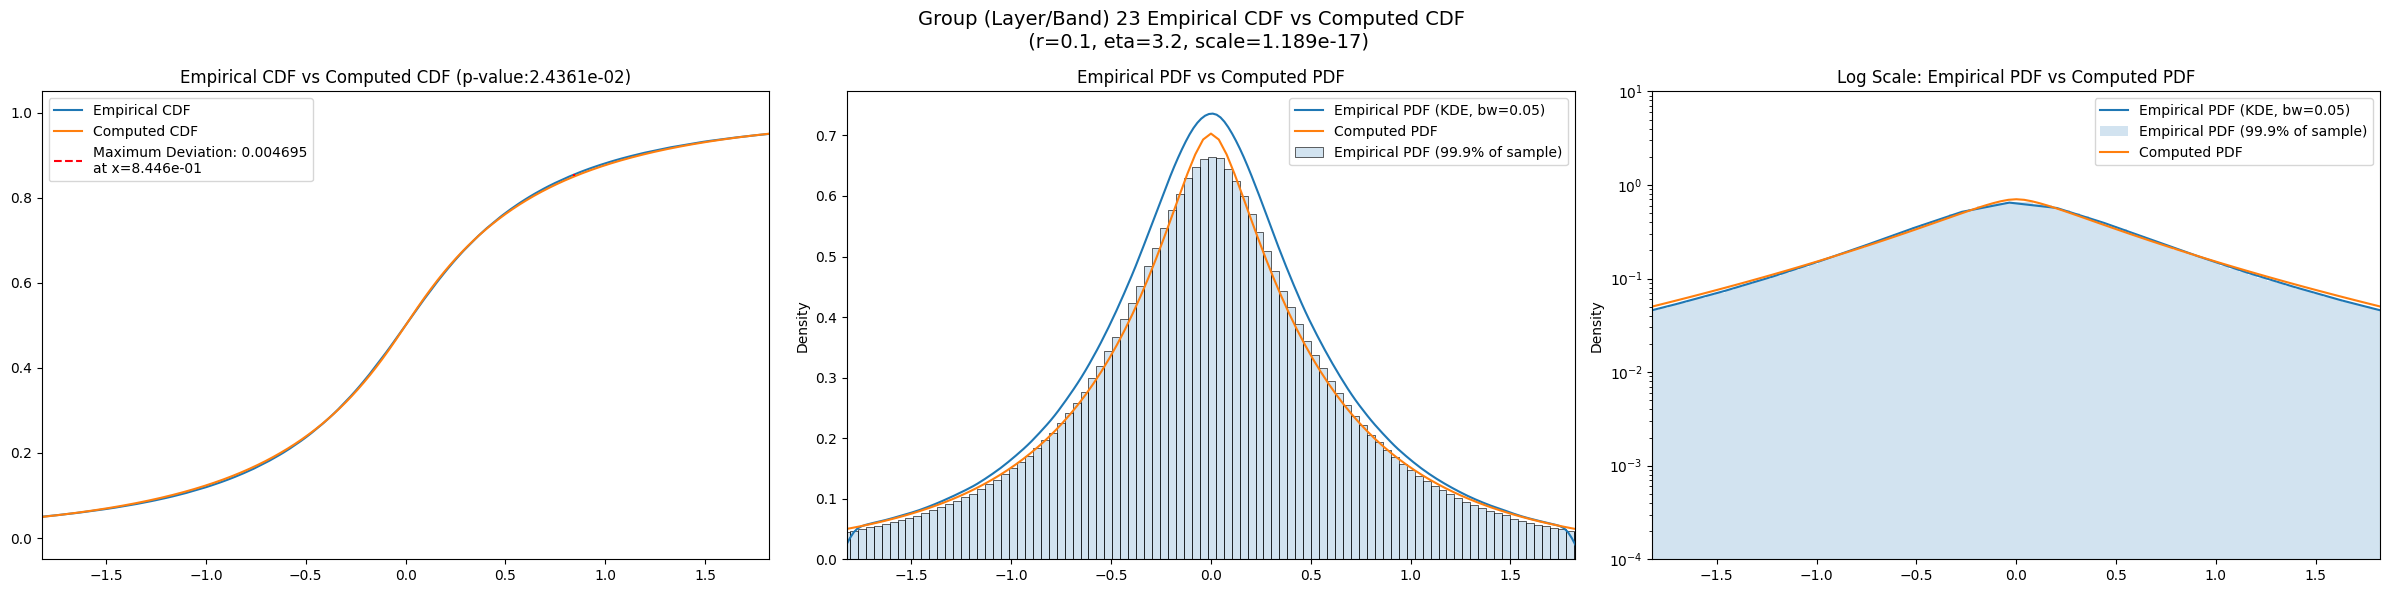

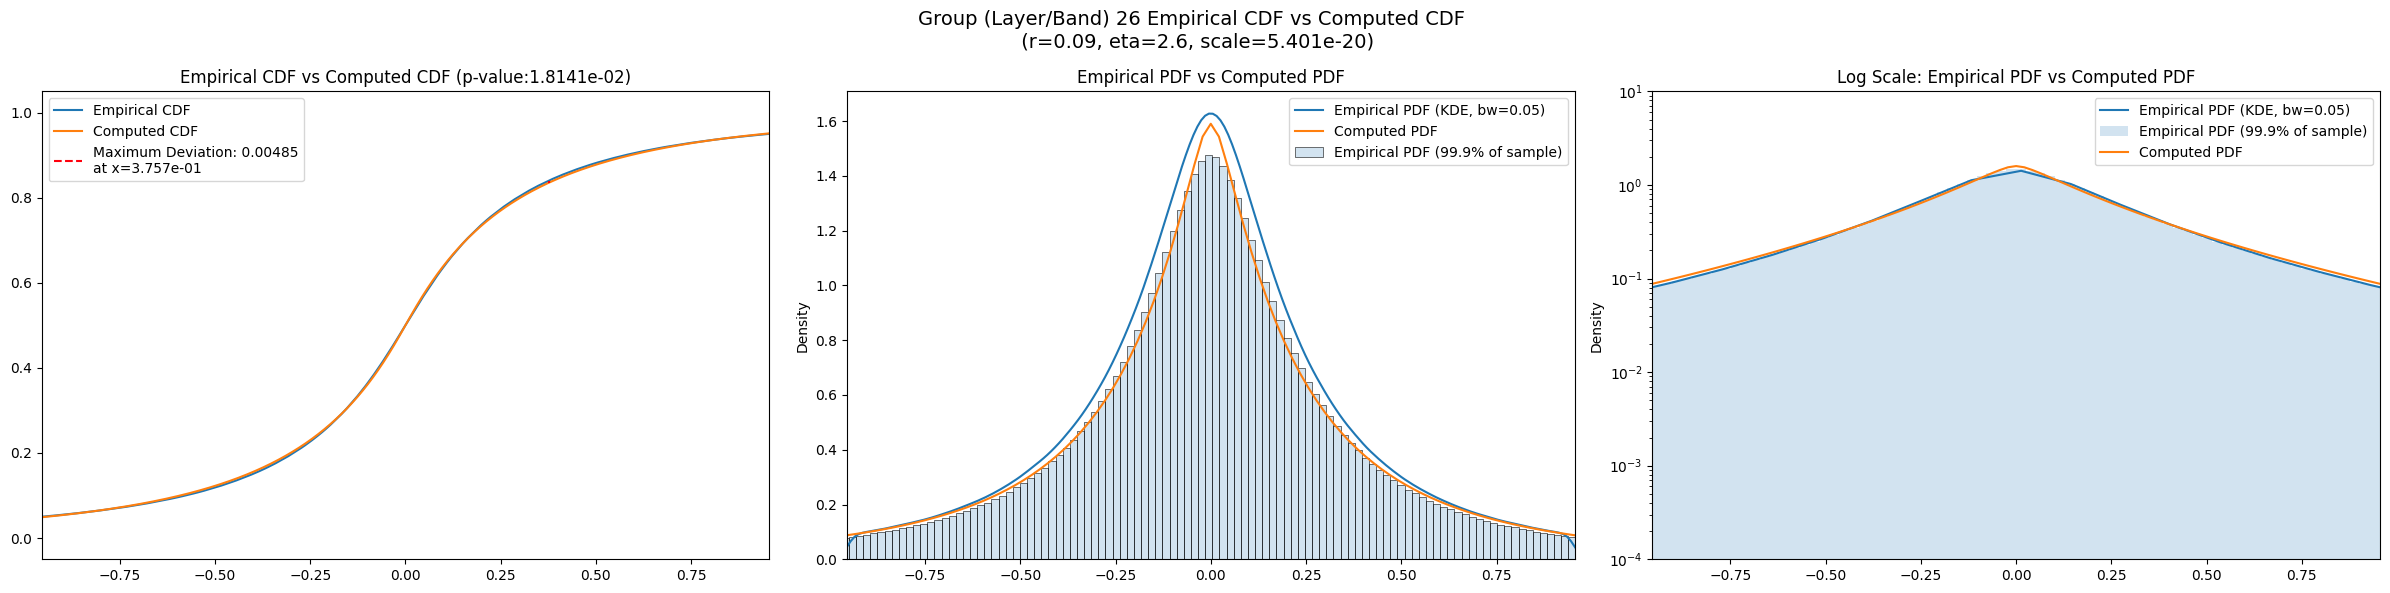

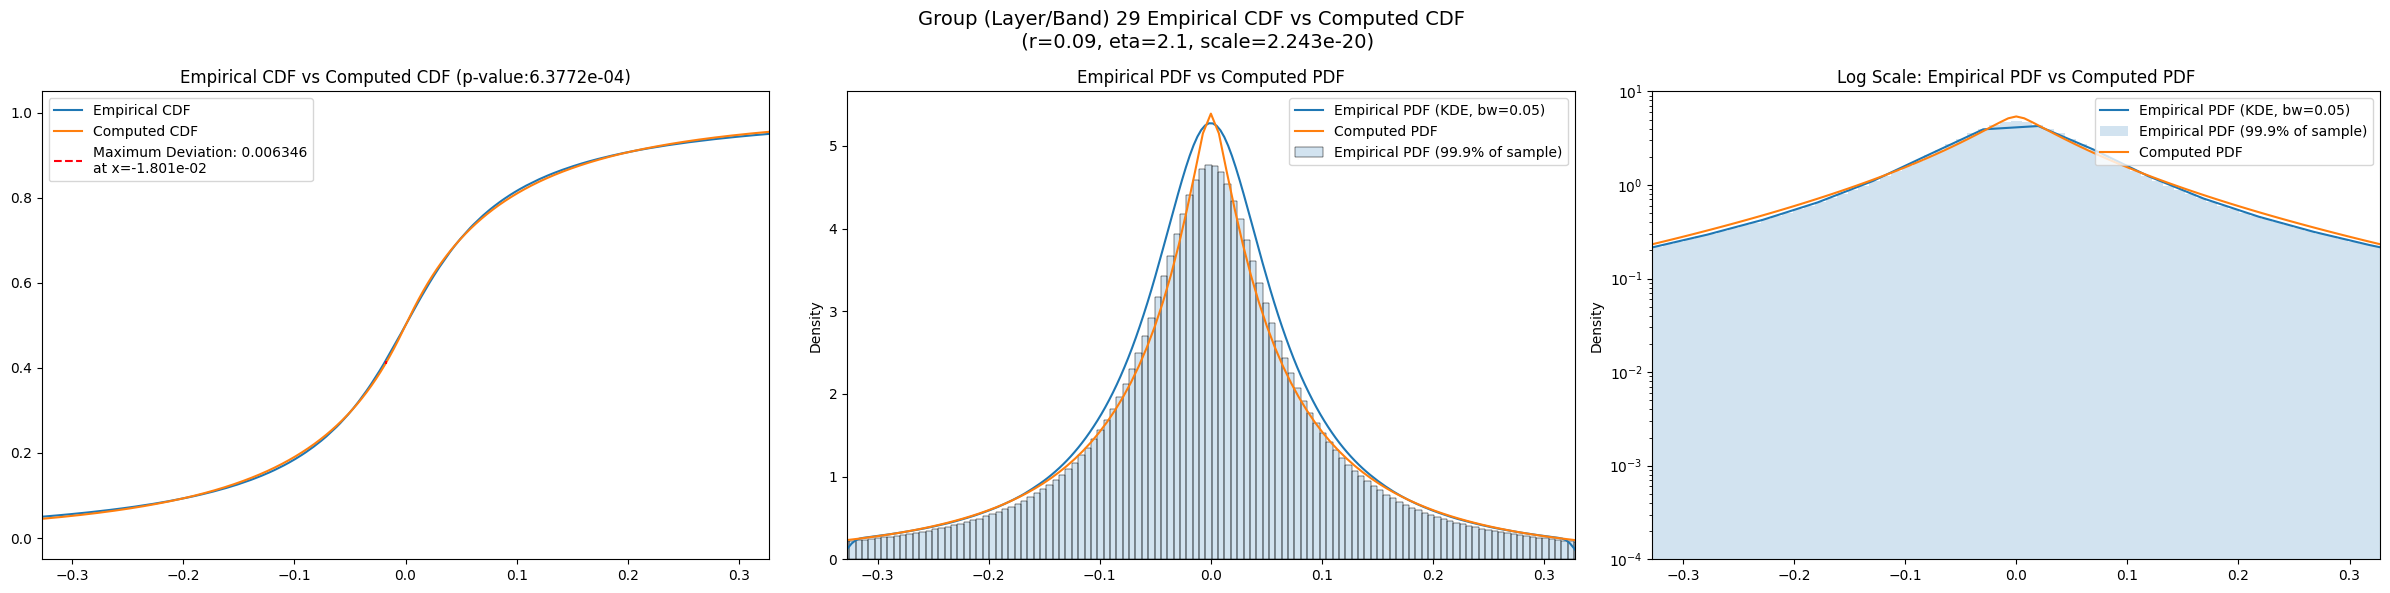

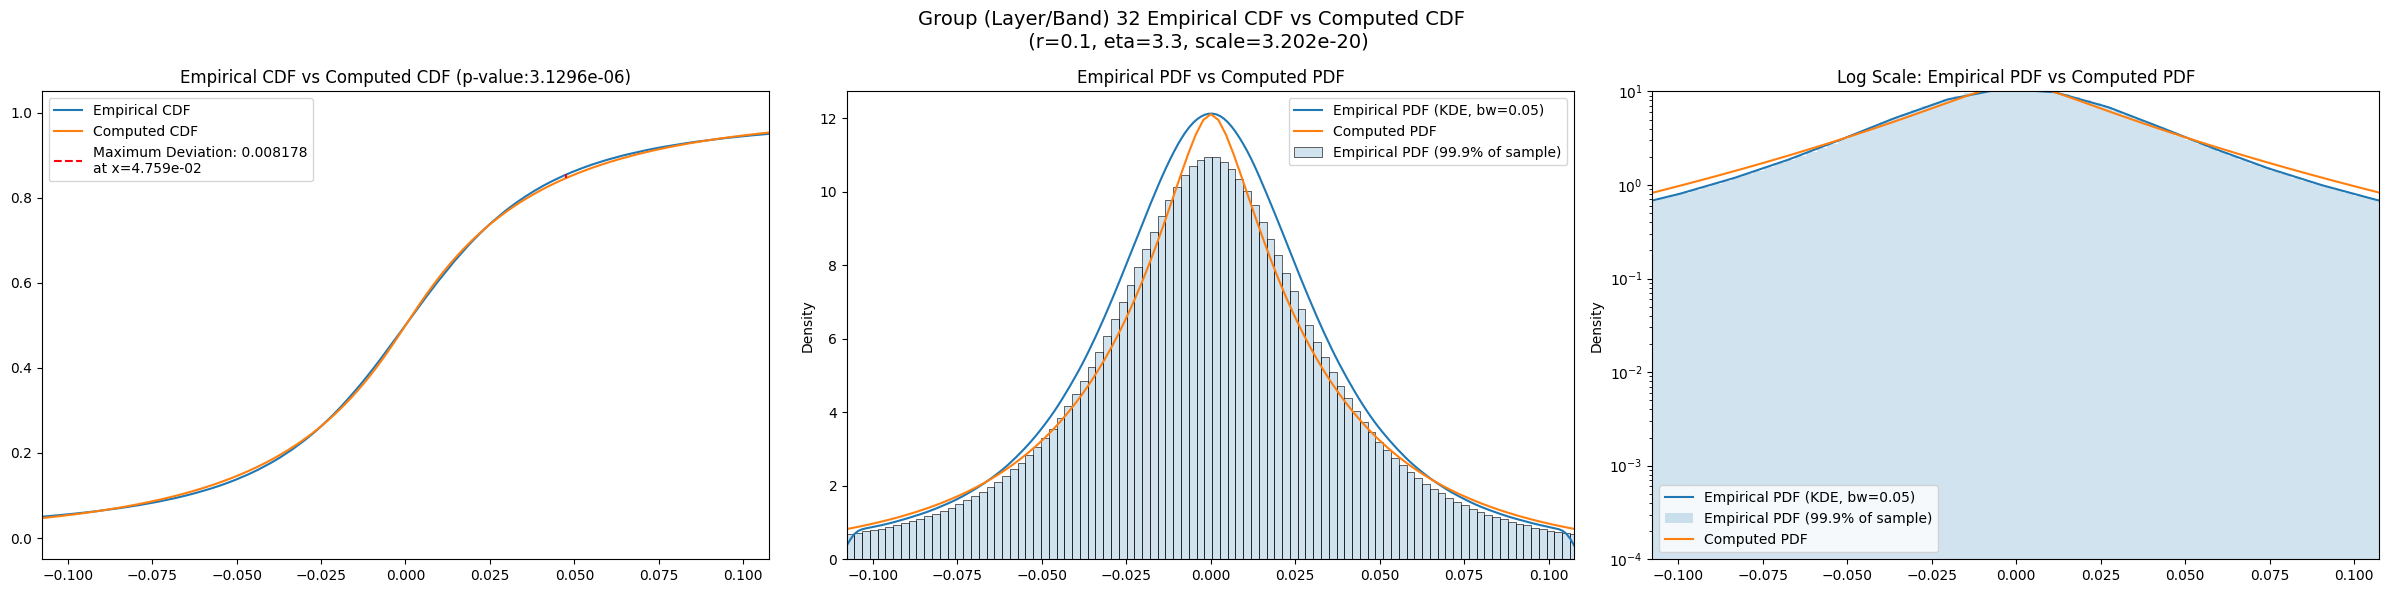

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var   var_lower    var_upper     obs_kurt  kurt_lower  \
band                                                                  
2     1690.463300  778.425800  4474.268600   1951.21090   93.389990   
5      925.186340  445.423340  2432.551000   1732.74070  102.459850   
8      286.479130  157.758420   630.313350    997.55035   76.816630   
11     254.842960   72.829560  1635.355600  13976.00800   62.877470   
14      74.946200   35.321682   283.324700   4449.84300   48.653390   
17      34.729362   17.269596   129.885730   4455.63230   42.402900   
20      15.656890    7.718547    51.575360   3024.86230   61.902660   
23       7.015059    2.579246    40.182514  11453.02000   71.847640   
26       4.446219    0.765977    42.104828  27543.82800   79.598564   
29       1.485536    0.097734    14.558654  38067.58200  100.885220   
32       0.048399    0.010321     0.300186  13939.49500   95.461980   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2      3809.4540        45000.0             0.006183        0.1          2.5   
5      3959.4731       117000.0             0.005385        0.1          2.5   
8      2699.5813       189000.0             0.004480        0.1          3.1   
11     8349.7330       495000.0             0.003599        0.1          3.5   
14     6157.9995      1134000.0             0.002984        0.1          3.7   
17     6093.3640      2574000.0             0.002845        0.1          3.4   
20     4879.5195      5967000.0             0.002774        0.1          3.3   
23     7815.2046     13887000.0             0.004336        0.1          3.2   
26     9199.3900     31968000.0             0.004770        0.1          2.2   
29     9678.4180     73701000.0             0.006696        0.1          1.8   
32     8480.3460     59634000.0             0.008780        0.1          3.4   

      ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band  ...                                                               
2     ...       12.470600              0.044028          3.074840e-76   
5     ...        8.726660              0.041173         8.895000e-173   
8     ...        5.998940              0.037180         1.935400e-227   
11    ...        4.544020              0.035271          0.000000e+00   
14    ...        3.407200              0.034096          0.000000e+00   
17    ...        2.429260              0.034877          0.000000e+00   
20    ...        1.500870              0.037194          0.000000e+00   
23    ...        0.817089              0.037800          0.000000e+00   
26    ...        0.395229              0.044218          0.000000e+00   
29    ...        0.125058              0.049812          0.000000e+00   
32    ...        0.047787              0.038349          0.000000e+00   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace   param_t  \
band                                                                      
2         11.121200             0.018637         5.232690e-14  8.737180   
5          7.776880             0.016246         2.976300e-27  6.128650   
8          5.321110             0.012882         1.127140e-27  4.235520   
11         4.012250             0.010895         1.823320e-51  3.215030   
14         3.009450             0.009953         5.271140e-98  2.419490   
17         2.146130             0.009883        8.787360e-219  1.725370   
20         1.322940             0.011672         0.000000e+00  1.065190   
23         0.720995             0.013563         0.000000e+00  0.578034   
26         0.350297             0.018980         0.000000e+00  0.278421   
29         0.110874             0.024687         0.000000e+00  0.088130   
32         0.041851             0.016720         0.000000e+00  0.033986   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
band                                                                   
2                0.006183                 0.006398          0.005747   
5                0.005385                 0.003969          0.005108   
8                0.004480                 0.003123          0.004159   
11               0.003599                 0.001930          0.003599   
14               0.002984                 0.001275          0.002984   
17               0.002845                 0.000846          0.002642   
20               0.002774                 0.000556          0.002492   
23               0.004336                 0.000364          0.004336   
26               0.004770                 0.000240          0.004508   
29               0.006696                 0.000158          0.006429   
32               0.008780                 0.000176          0.007815   

      kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
band                                                            
2                 0.044028             0.018637       0.015720  
5                 0.041173             0.016246       0.011878  
8                 0.037180             0.012882       0.009419  
11                0.035271             0.010895       0.007017  
14                0.034096             0.009953       0.006253  
17                0.034877             0.009883       0.007474  
20                0.037194             0.011672       0.008923  
23                0.037800             0.013563       0.007941  
26                0.044218             0.018980       0.014344  
29                0.049812             0.024687       0.019330  
32                0.038349             0.016720       0.007250

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
band                                                                         
2             403.564240          0.005747    0.10       2.7  8.703552e-15   
5             206.622513          0.005108    0.10       2.4  8.705412e-15   
8              86.440742          0.004159    0.09       3.5  1.371833e-18   
11             44.661514          0.003599    0.10       3.5  1.958911e-16   
14             24.630728          0.002984    0.10       3.7  7.526925e-17   
17             12.734529          0.002642    0.10       3.6  4.654606e-17   
20              5.262650          0.002492    0.09       3.7  5.591976e-20   
23              1.536807          0.004336    0.10       3.2  1.189379e-17   
26              0.455964          0.004508    0.09       2.6  5.401472e-20   
29              0.051707          0.006429    0.09       2.1  2.242610e-20   
32              0.005017          0.007815    0.10       3.3  3.201669e-20   

      best_exclude_cutoff  
band                       
2                   125.0  
5                   325.0  
8                   275.0  
11                  250.0  
14                  200.0  
17                  175.0  
20                  175.0  
23                  250.0  
26                  225.0  
29                  275.0  
32                  425.0

In [21]:
eng.quit()